# <center> RESPIRATION RATE ESTIMATION
 
 **08/02/2023**   
    
 **Group 7:** **Giovanni Zago**, **Enrico Lupi**, **Emanuele Sarte**, **Alessio Saccomani** 
 
   The aim of this project is to estimate the Respiratory Rate (RR) by Seismocardiography(SCG), a technique where the detector is positioned above sternum, and Ballistocardiography (BCG), in which there is no contact between the sensor and the body: in this study the sensor was placed....). The measurements were taken using the detector MuSe (Multi-sensor miniaturized, low-power, wireless Inertial Measurement Unit), provided by 221e (https://www.221e.com). An IMU is a combination of an accelerometer and a gyroscope sensor, capable of detecting movements and measuring their intensity in terms of acceleration and rotational speeds. Sometimes, like in this case, a magnetometer is also included. 

In [1]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://www.221e.com/wp-content/uploads/2022/10/221e-Muse1.jpg", width=400, height=300)


In [2]:
Image(url= "https://embeddedinventor.com/wp-content/uploads/2019/07/imu1.jpg?ezimgfmt=ng:webp/ngcb7")

# Download Data and First Steps

First, we import the necessary libraries for the analysis (pandas, numpy, matplotlib, scipy, ecc.). 

We then download the datafile 'center_sternum.txt' as a pandas dataframe. For the following analysis we decide to take into account the linear acceleration (in mg), the angular velocity (in degrees per second) and the magnetic field (in mG) in all three directions; the quaternions are not considered, instead, so they are dropped. Afterwards, we calibrate the measurements using the information in the file README_1.txt and we addto the dataset the absolute time at which every measuremnt is taken: as the data collection frequency is 200 Hz, each measurement is taken every 5 ms. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy import fft
from scipy import signal
from scipy import optimize
from scipy import linalg
import seaborn as sns
import pywt
sns.set_theme(style="ticks")

In [4]:
file_name = "center_sternum.txt"#"1_Stave_supine_static.txt"#
raw_data = pd.read_csv(file_name, sep="\t")

# We drop the columns we are not going to use
raw_data = raw_data.drop(["Log Mode", "qw", "qi", "qj", "qk"], axis=1)

# We look that the data collection frequency is the same for all the dataset
if len(raw_data["Log Freq"].unique()) != 1:
    print("There is more than one frequency")
    exit(1)

# We select the frequency
ACQ_FREQ = raw_data.loc[0, "Log Freq"]

# We create a column with the absolute time by multiplying 1/freq by integers
raw_data.insert(2, "Abs Time", np.arange(0, len(raw_data)) * (1 / ACQ_FREQ), allow_duplicates=False)

display(raw_data)


Log Freq   Timestamp  Abs Time     AccX     AccY    AccZ      GyroX  \
0           200  1576222772     0.000  947.086  435.662  70.638  -6.824428   
1           200  1576222772     0.005  969.168  387.777  88.877   6.183206   
2           200  1576222772     0.010  989.603  380.335  78.751  11.709920   
3           200  1576222772     0.015  954.894  418.033  88.328  17.877860   
4           200  1576222772     0.020  972.096  427.732  99.857  25.221370   
...         ...         ...       ...      ...      ...     ...        ...   
16501       200  1576222847    82.505  958.493  291.092 -54.290   1.664122   
16502       200  1576222847    82.510  954.650  288.042 -49.654   1.480916   
16503       200  1576222847    82.515  967.338  290.482 -63.867   1.114504   
16504       200  1576222847    82.520  965.630  300.852 -56.242   0.702290   
16505       200  1576222847    82.525  959.957  298.473 -55.998   0.290076   

           GyroY     GyroZ  MagnX  MagnY  MagnZ  
0     -14.244280  1.404580   -454   -490   -178  
1     -12.290080 -7.969466   -454   -490   -177  
2      -4.961832 -7.450382   -454   -490   -177  
3       2.519084 -5.984733   -454   -492   -176  
4       5.404580  4.015267   -454   -492   -176  
...          ...       ...    ...    ...    ...  
16501   2.305344 -0.671756   -494   -449   -126  
16502   2.488550 -0.702290   -494   -450   -125  
16503   3.374046 -0.900763   -494   -450   -125  
16504   3.664122 -1.587786   -495   -448   -124  
16505   4.061069 -1.343511   -495   -448   -124  

[16506 rows x 12 columns]

In [5]:
#calibrate the dataset
offset_gyro = np.array([-2.242224, 2.963463, -0.718397])

calibration_acc = np.array([[1.000966, -0.002326418, -0.0006995499],
                            [-0.002326379, 0.9787045, -0.001540918],
                            [-0.0006995811, -0.001540928, 1.00403]])
offset_acc = np.array([-3.929942, -13.74679, 60.67546])

calibration_magn = np.array([[0.9192851, -0.02325168, 0.003480837],
                             [-0.02325175, 0.914876, 0.004257396],
                             [0.003481006, 0.004257583, 0.8748001]])
offset_magn = np.array([-95.67974, -244.9142, 17.71132])

raw_data[['AccX', 'AccY', 'AccZ']] = np.dot(raw_data[['AccX', 'AccY', 'AccZ']], calibration_acc.T) + offset_acc.T
raw_data[['GyroX', 'GyroY', 'GyroZ']] = raw_data[['GyroX', 'GyroY', 'GyroZ']] + offset_gyro.T
raw_data[['MagnX', 'MagnY', 'MagnZ']] = np.dot(raw_data[['MagnX', 'MagnY', 'MagnZ']], calibration_magn.T) + offset_magn.T

display(raw_data)

Log Freq   Timestamp  Abs Time        AccX        AccY        AccZ  \
0           200  1576222772     0.000  943.007996  410.325442  130.264244   
1           200  1576222772     0.005  965.209969  363.380701  148.635086   
2           200  1576222772     0.010  985.689106  356.065246  138.465450   
3           200  1576222772     0.015  950.852176  393.026437  148.047237   
4           200  1576222772     0.020  968.040164  402.461108  159.595720   
...         ...         ...       ...         ...         ...         ...   
16501       200  1576222847    82.505  954.849739  269.000099    5.047576   
16502       200  1576222847    82.510  951.006879  266.016847    9.709647   
16503       200  1576222847    82.515  963.711402  268.397270   -4.573267   
16504       200  1576222847    82.520  961.972293  278.538659    3.067677   
16505       200  1576222847    82.525  956.299177  276.223143    3.320295   

           GyroX      GyroY     GyroZ       MagnX       MagnY       MagnZ  
0      -9.066652 -11.280817  0.686183 -502.261441 -683.404962 -141.669690  
1       3.940982  -9.326617 -8.687863 -502.257960 -683.400705 -140.794890  
2       9.467696  -1.998369 -8.168779 -502.257960 -683.400705 -140.794890  
3      15.635636   5.482547 -6.703130 -502.207976 -685.226199 -139.928605  
4      22.979146   8.368043  3.296870 -502.207976 -685.226199 -139.928605  
...          ...        ...       ...         ...         ...         ...  
16501  -0.578102   5.268807 -1.390153 -539.805161 -644.743591  -96.144764  
16502  -0.761308   5.452013 -1.420687 -539.778428 -645.654210  -95.274222  
16503  -1.127720   6.337509 -1.619160 -539.778428 -645.654210  -95.274222  
16504  -1.539934   6.627585 -2.306183 -540.740736 -643.796949  -94.394388  
16505  -1.952148   7.024532 -2.061908 -540.740736 -643.796949  -94.394388  

[16506 rows x 12 columns]

# Data Visualization

We now plot the accelerations, the angular velocity and the magnetic field components as a function of time in order to look at their general trend and to select a proper time window to conduct the analysis in. This is necessary as signals are very disturbed at the beginning and end of the data taking, probably due to sudden movements of the test subject: they are ususally used to coordinate the data taking across various devices, but they mud the data and need of course to be eliminated. 

From 10 to 65 seconds all features have a regular behaviour and thus we select this to be the time window to be used in the rest of the project. In the plots this time window is highlighted.

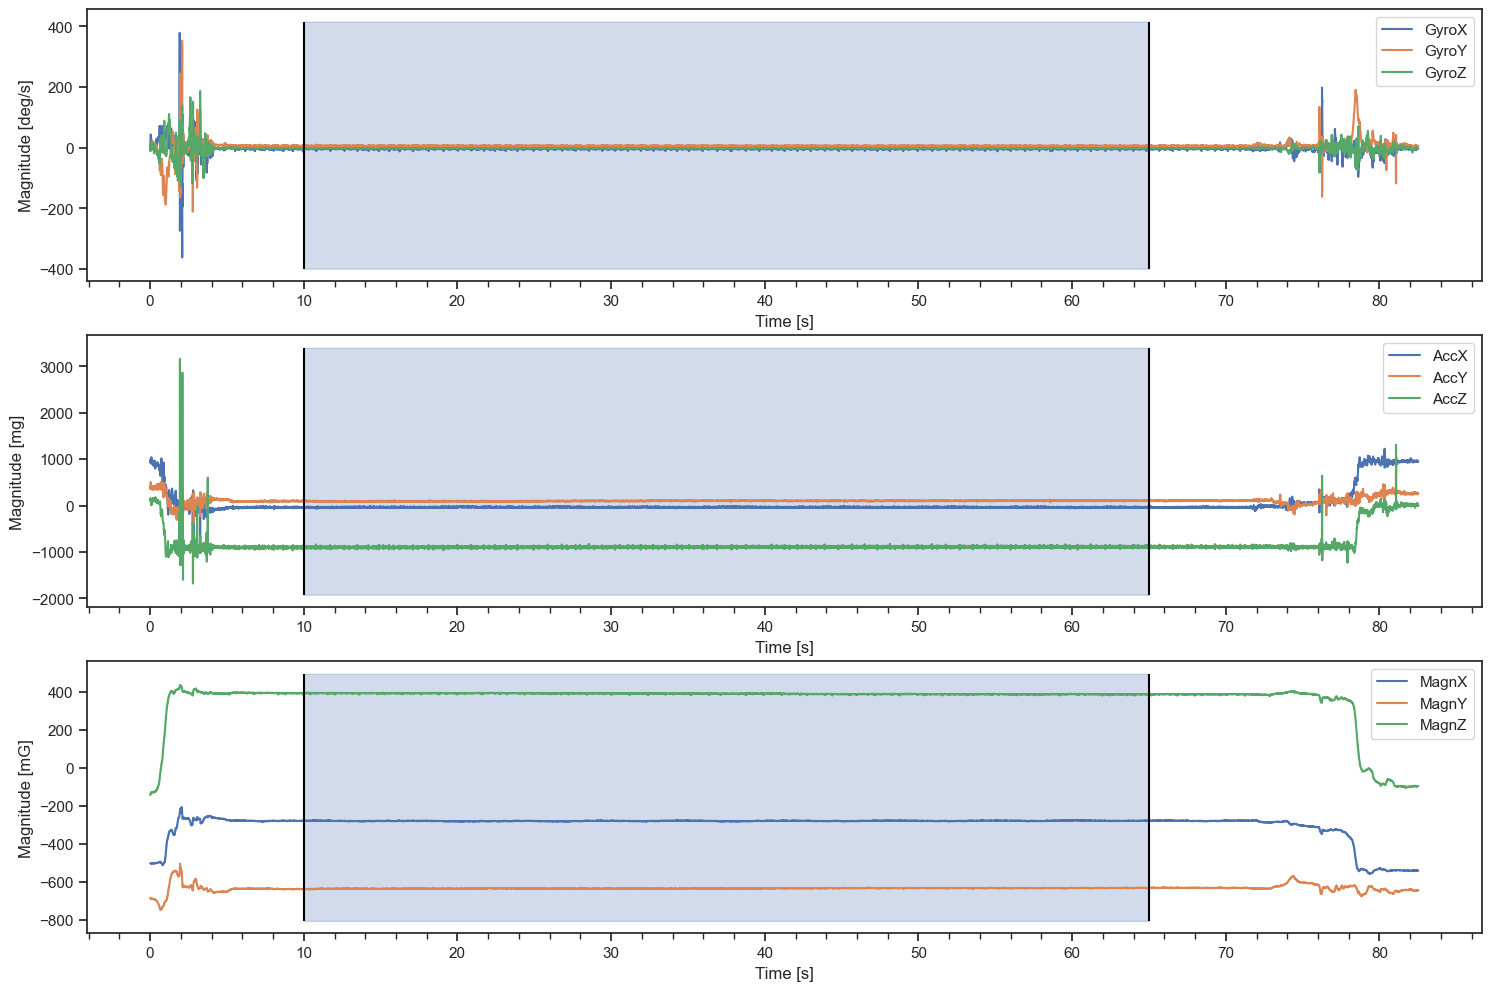

Log Freq   Timestamp  Abs Time       AccX        AccY        AccZ  \
2000        200  1576222781    10.000 -36.191918   98.305357 -897.115495   
2001        200  1576222781    10.005 -22.684157   97.764133 -915.007862   
2002        200  1576222781    10.010 -31.003173   96.009994 -887.561201   
2003        200  1576222781    10.015 -25.334931   99.274992 -884.079327   
2004        200  1576222781    10.020 -35.980596  103.453468 -867.603353   
...         ...         ...       ...        ...         ...         ...   
12996       200  1576222831    64.980 -44.203217  102.317144 -892.706502   
12997       200  1576222831    64.985 -36.631201  102.001043 -892.711324   
12998       200  1576222831    64.990 -28.811253  103.792989 -905.152510   
12999       200  1576222831    64.995 -46.173206  104.746772 -877.948746   
13000       200  1576222831    65.000 -46.147234   99.342746 -896.681416   

          GyroX     GyroY     GyroZ       MagnX       MagnY       MagnZ  
2000  -0.486499  7.986364 -1.527557 -278.856972 -639.776198  393.017911  
2001  -0.684972  7.161936 -1.802366 -278.856972 -639.776198  393.017911  
2002  -1.310926  7.284074 -1.817634 -278.021365 -637.071851  389.534964  
2003  -1.295659  7.100867 -1.985573 -278.021365 -637.071851  389.534964  
2004  -1.219323  7.665753 -1.710763 -278.876743 -638.857065  393.896969  
...         ...       ...       ...         ...         ...         ...  
12996 -3.371995  6.978730 -1.237481 -277.248552 -631.614362  387.814391  
12997 -3.356728  6.551249 -1.435954 -277.264842 -630.690971  389.568248  
12998 -3.799476  6.902394 -1.359618 -277.264842 -630.690971  389.568248  
12999 -3.814743  6.978730 -1.771832 -278.187608 -630.671977  388.689967  
13000 -3.768942  6.932929 -1.695496 -278.187608 -630.671977  388.689967  

[11001 rows x 12 columns]

In [6]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

labels = ["GyroX", "GyroY", "GyroZ", "AccX", "AccY", "AccZ", "MagnX", "MagnY", "MagnZ"]
unit = ["[deg/s]", "[mg]", "[mG]"]
Nvar = len(labels)

T1_CUT = 10     
IT1_CUT = round(T1_CUT * ACQ_FREQ)
T2_CUT = 65 # included
IT2_CUT = round(T2_CUT * ACQ_FREQ) + 1

plt.figure(figsize=(18, 4 * (Nvar // 3)))
for i in range(Nvar // 3):
    ax = plt.subplot(Nvar // 3, 1, i + 1)
    plt.plot(raw_data["Abs Time"], raw_data[labels[i * 3]],     label=labels[i * 3])
    plt.plot(raw_data["Abs Time"], raw_data[labels[i * 3 + 1]], label=labels[i * 3 + 1])
    plt.plot(raw_data["Abs Time"], raw_data[labels[i * 3 + 2]], label=labels[i * 3 + 2])
    ymin, ymax = plt.ylim()
    plt.vlines(x=raw_data.loc[IT1_CUT, "Abs Time"], ymin=ymin, ymax=ymax, colors="black")
    plt.vlines(x=raw_data.loc[IT2_CUT, "Abs Time"], ymin=ymin, ymax=ymax, colors="black")

    ax.fill_between(raw_data.loc[IT1_CUT: IT2_CUT, "Abs Time"], ymin, ymax, color='C0', alpha=0.25)

    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    plt.xlabel("Time [s]")
    plt.ylabel("Magnitude "+unit[i])
    plt.legend()

plt.show()

raw_data_cut = raw_data.loc[IT1_CUT: IT2_CUT - 1, :]
display(raw_data_cut)

# Statistical Analysis

We calculate the mean, standard deviation, minimum, 25th, 50th, 75th percentiles and maximum for all features (in the selected time window); data is then normalized. 
For the accelerations and the angular velocities the 25th and 75th percentiles are nearly symmetric, so the variables change quite regularly, while we notice a higher deviation for the acceleration along X and the angular velocity along Z. 

Afterwards, normalized data is plotted in a 9x9 grid in order highlight possible correlations.

In [8]:
raw_data_cut.drop(["Log Freq", "Timestamp", "Abs Time"], axis=1).describe()

AccX          AccY          AccZ         GyroX         GyroY  \
count  11001.000000  11001.000000  11001.000000  11001.000000  11001.000000   
mean     -34.125429    100.654133   -892.862843     -4.319344      6.651708   
std        7.033450      5.224951     14.452377      1.425395      0.717895   
min      -70.523078     71.834825   -959.109087    -12.242224      3.467280   
25%      -38.758325     97.171078   -901.407869     -4.929247      6.245906   
50%      -34.010220    100.808275   -893.309854     -4.394896      6.597051   
75%      -29.448412    104.096712   -885.126901     -3.707873      6.963463   
max       -8.963639    131.953547   -822.777963      2.231058     10.520715   

              GyroZ         MagnX         MagnY         MagnZ  
count  11001.000000  11001.000000  11001.000000  11001.000000  
mean      -1.586729   -278.723389   -633.791766    391.294005  
std        0.364948      1.204988      1.564649      2.524112  
min       -3.222214   -282.650371   -639.776198    380.808251  
25%       -1.832901   -279.865783   -635.178566    389.537294  
50%       -1.573359   -278.969750   -633.439856    391.293856  
75%       -1.344351   -278.057426   -632.497471    393.908188  
max       -0.077176   -274.460483   -629.710597    396.544210

In [9]:
data_std = (raw_data_cut[labels] - np.mean(raw_data_cut[labels], axis=0)) / np.std(raw_data_cut[labels], axis=0)
data_std.insert(0, "Abs Time", raw_data_cut["Abs Time"])
data_std.set_index(np.arange(0, len(data_std)), inplace=True)
display(data_std)

Abs Time     GyroX     GyroY     GyroZ      AccX      AccY      AccZ  \
0        10.000  2.689093  1.859209  0.162144 -0.293822 -0.449551 -0.294266   
1        10.005  2.549846  0.710761 -0.590898  1.626768 -0.553141 -1.532345   
2        10.010  2.110682  0.880902 -0.632736  0.443935 -0.888879  0.366852   
3        10.015  2.121393  0.625690 -1.092929  1.249870 -0.263965  0.607783   
4        10.020  2.174950  1.412590 -0.339885 -0.263776  0.535787  1.747853   
...         ...       ...       ...       ...       ...       ...       ...   
10996    64.980  0.664652  0.455550  0.957024 -1.432902  0.318297  0.010818   
10997    64.985  0.675364 -0.139942  0.413159 -0.356281  0.257796  0.010484   
10998    64.990  0.364735  0.349212  0.622338  0.755592  0.600771 -0.850395   
10999    64.995  0.354024  0.455550 -0.507227 -1.713003  0.783323  1.031995   
11000    65.000  0.386158  0.391748 -0.298049 -1.709311 -0.250997 -0.264230   

          MagnX     MagnY     MagnZ  
0     -0.110863 -3.824949  0.683006  
1     -0.110863 -3.824949  0.683006  
2      0.582625 -2.096466 -0.696926  
3      0.582625 -2.096466 -0.696926  
4     -0.127272 -3.237485  1.031286  
...         ...       ...       ...  
10996  1.223999  1.391687 -1.378612  
10997  1.210479  1.981872 -0.683739  
10998  1.210479  1.981872 -0.683739  
10999  0.444656  1.994013 -1.031712  
11000  0.444656  1.994013 -1.031712  

[11001 rows x 10 columns]

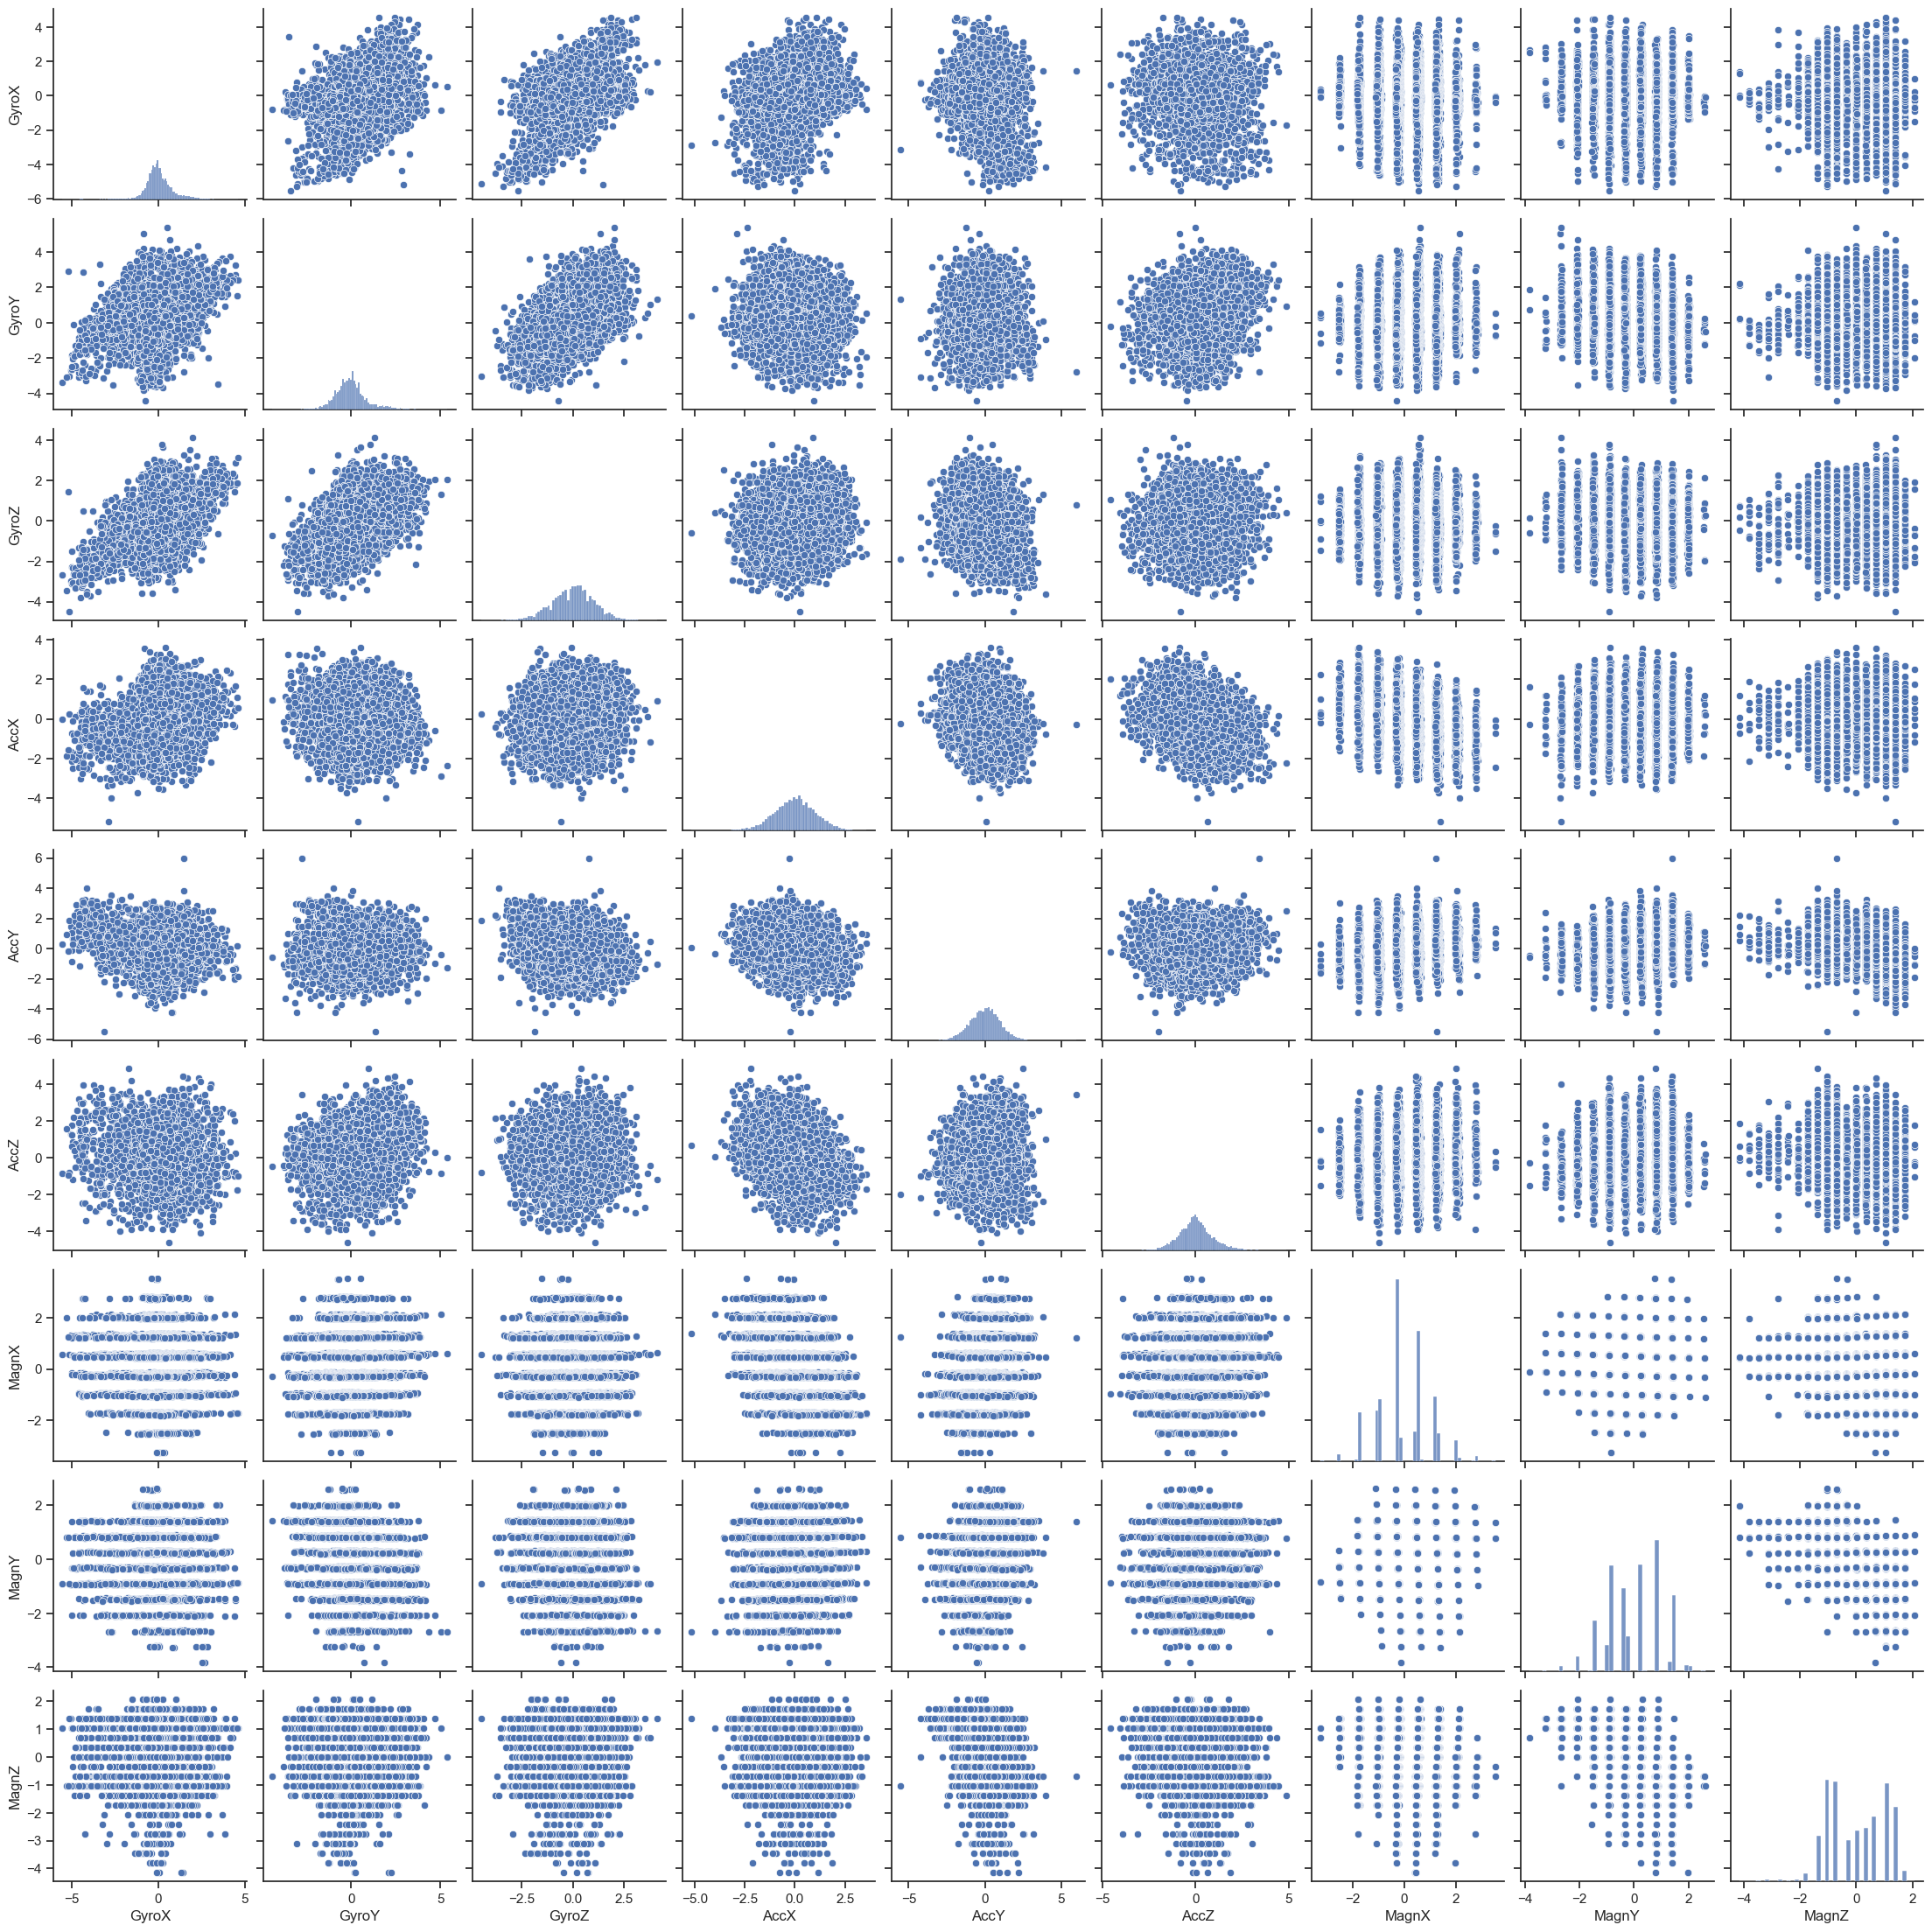

In [10]:
sns.pairplot(data_std[labels]);

# PCA

In order to reduce the dimensionality of the dataset we perform a PCA, keeping only 6 out of the total 9 principal components so as to maintain at least 85% of the total variability.

In [11]:
avls, avts = linalg.eig(np.cov(data_std[labels].T))
sort_perm = np.flip(np.argsort(avls))

avls = np.real_if_close(avls[sort_perm])
avts = avts[:, sort_perm]

var_ratios = avls / np.sum(avls)
print('Eigenvalues (sorted):\n', np.round(avls, 4)) #todo tenere la troncatura?
print('Variability ratios:\n', np.round(var_ratios * 100, 2))
print("Eigenvector:")
display(pd.DataFrame(avts, columns=[f"Avt {i+1}" for i in range(len(avls))]))

Eigenvalues (sorted):
 [2.4787 1.7799 1.3701 0.8805 0.7382 0.5773 0.5298 0.4009 0.2454]
Variability ratios:
 [27.54 19.78 15.22  9.78  8.2   6.41  5.89  4.45  2.73]
Eigenvector:


Avt 1     Avt 2     Avt 3     Avt 4     Avt 5     Avt 6     Avt 7  \
0  0.182888  0.518853  0.200911 -0.113755 -0.183171 -0.716156 -0.298493   
1  0.124385  0.580960 -0.128268  0.036783 -0.258641  0.244809  0.638616   
2  0.148762  0.556458 -0.033822  0.000907  0.417231  0.480584 -0.449112   
3  0.290740 -0.019744  0.645695  0.098572 -0.027473  0.012302  0.343172   
4 -0.418706  0.081714  0.130817 -0.099433 -0.737659  0.289169 -0.302951   
5 -0.282156  0.160740 -0.429412  0.655244 -0.001573 -0.273269  0.088747   
6 -0.352783  0.120183 -0.231093 -0.708337  0.211525 -0.174252  0.273443   
7 -0.460078  0.073331  0.398113  0.167226  0.345991 -0.070861  0.044378   
8  0.503355 -0.175801 -0.334233 -0.083973 -0.126969 -0.048963 -0.084890   

      Avt 8     Avt 9  
0  0.087567  0.029009  
1  0.300133 -0.066868  
2 -0.240885 -0.048063  
3 -0.601776 -0.087379  
4 -0.186221 -0.191810  
5 -0.440214 -0.066845  
6 -0.379926 -0.108323  
7  0.325520 -0.603182  
8 -0.057613 -0.753605

In [12]:
PCA_LABELS = [f"PC{i+1}" for i in range(len(avls))]
data_rot = pd.DataFrame(data=np.dot(avts.T, data_std[labels].T).T, columns=PCA_LABELS)

perc_thr = .85
N_PCA = np.argmax(np.cumsum(var_ratios) >= perc_thr) + 1

print(f'To keep {int(perc_thr * 100)}% of variability in our dataset we need {N_PCA} out of the {len(var_ratios)} principal components')

display(data_rot)

PCA_LABELS = PCA_LABELS[:N_PCA]
data_pca = data_rot[data_rot.columns[:N_PCA]]
data_pca.insert(0, "Abs Time", data_std["Abs Time"])
display(data_pca)



To keep 85% of variability in our dataset we need 6 out of the 9 principal components


PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0      3.075695  2.073479 -1.551284 -1.032899 -1.999198 -1.189014  0.063028   
1      3.746452  0.669598  0.351727 -1.671614 -1.965251 -1.400342  0.289974   
2      1.207398  1.271186 -0.391031 -0.540507 -0.749164 -1.870673  0.796333   
3      1.013835  0.946276  0.158099 -0.376356 -1.360618 -2.037202  0.945469   
4      1.782219  1.655941 -2.187663  0.332393 -2.574286 -1.499982  0.041799   
...         ...       ...       ...       ...       ...       ...       ...   
10996 -1.998359  1.689615 -0.113521 -0.742299  0.879743 -0.077483 -0.410998   
10997 -1.729927  0.939818  0.676640 -0.604072  0.933046 -0.569957 -0.198958   
10998 -1.272213  1.046921  1.676883 -1.039144  0.668515  0.220885  0.313458   
10999 -2.664835  0.810843 -0.380989  0.510612 -0.011728 -0.630616 -0.022866   
11000 -1.835889  0.613902  0.050268 -0.241335  0.851076 -0.513550  0.032432   

            PC8       PC9  
0     -0.097831  1.881899  
1     -0.864770  1.925656  
2     -0.525130  1.866565  
3     -1.197361  1.699668  
4     -1.079108  0.977814  
...         ...       ...  
10996  0.830064  0.073153  
10997  0.304033 -0.821209  
10998  0.019259 -0.978377  
10999  1.260179 -0.538782  
11000  1.954462 -0.258921  

[11001 rows x 9 columns]

Abs Time       PC1       PC2       PC3       PC4       PC5       PC6
0        10.000  3.075695  2.073479 -1.551284 -1.032899 -1.999198 -1.189014
1        10.005  3.746452  0.669598  0.351727 -1.671614 -1.965251 -1.400342
2        10.010  1.207398  1.271186 -0.391031 -0.540507 -0.749164 -1.870673
3        10.015  1.013835  0.946276  0.158099 -0.376356 -1.360618 -2.037202
4        10.020  1.782219  1.655941 -2.187663  0.332393 -2.574286 -1.499982
...         ...       ...       ...       ...       ...       ...       ...
10996    64.980 -1.998359  1.689615 -0.113521 -0.742299  0.879743 -0.077483
10997    64.985 -1.729927  0.939818  0.676640 -0.604072  0.933046 -0.569957
10998    64.990 -1.272213  1.046921  1.676883 -1.039144  0.668515  0.220885
10999    64.995 -2.664835  0.810843 -0.380989  0.510612 -0.011728 -0.630616
11000    65.000 -1.835889  0.613902  0.050268 -0.241335  0.851076 -0.513550

[11001 rows x 7 columns]

# Fourier Analysis

We then perform a Fourier analysis using the scipy fftpack library in order to extrapolate the principal frequencies of the data and see if a peak is present near the respiratory rate (around 0.2 Hz).

We first plot as an example the whole power spectrum of PC3: we can clearly see a peak around 0.2 Hz due to respiration and one around 1.1 Hz corresponding to the heart rate, while the peaks at high frequencies are due to noise. As we are only interested in the respiratory rate, all following plots will be focused only in the [0, 0.9] Hz range.

In [13]:
sig_fft = fft.fftshift(fft.fft(data_pca[PCA_LABELS], axis=0))
sample_freq = fft.fftshift(fft.fftfreq(len(data_pca), d=1/ACQ_FREQ))

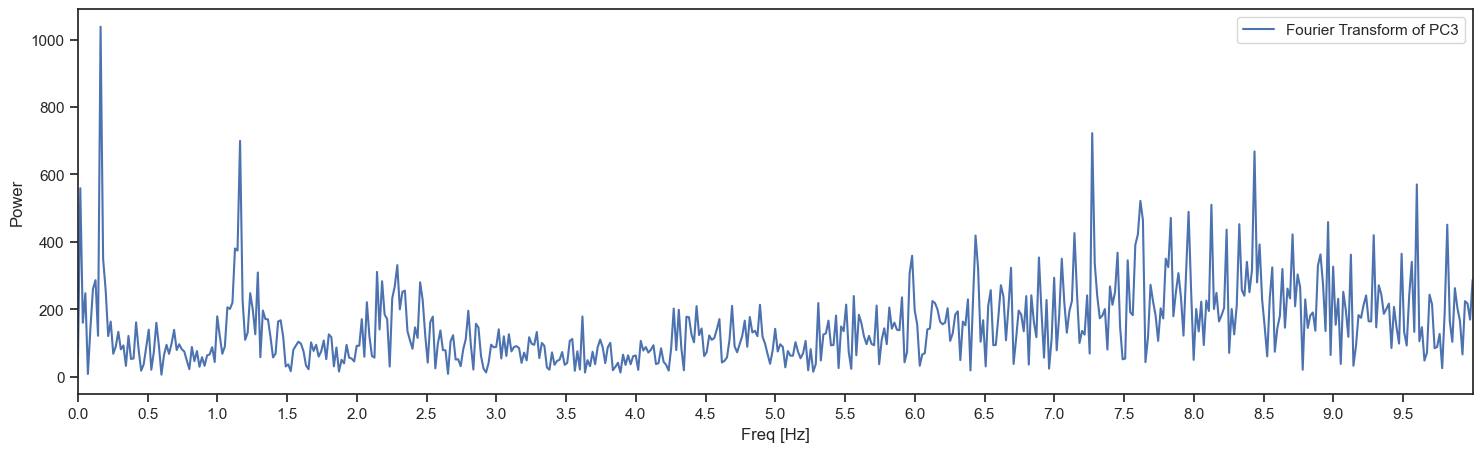

In [14]:
plt.figure(figsize=(18, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(sample_freq, np.abs(sig_fft[:, 2]), label="Fourier Transform of " + PCA_LABELS[2])
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 10, 0.5))
plt.xlabel("Freq [Hz]")
plt.ylabel("Power")
plt.legend(loc="best");

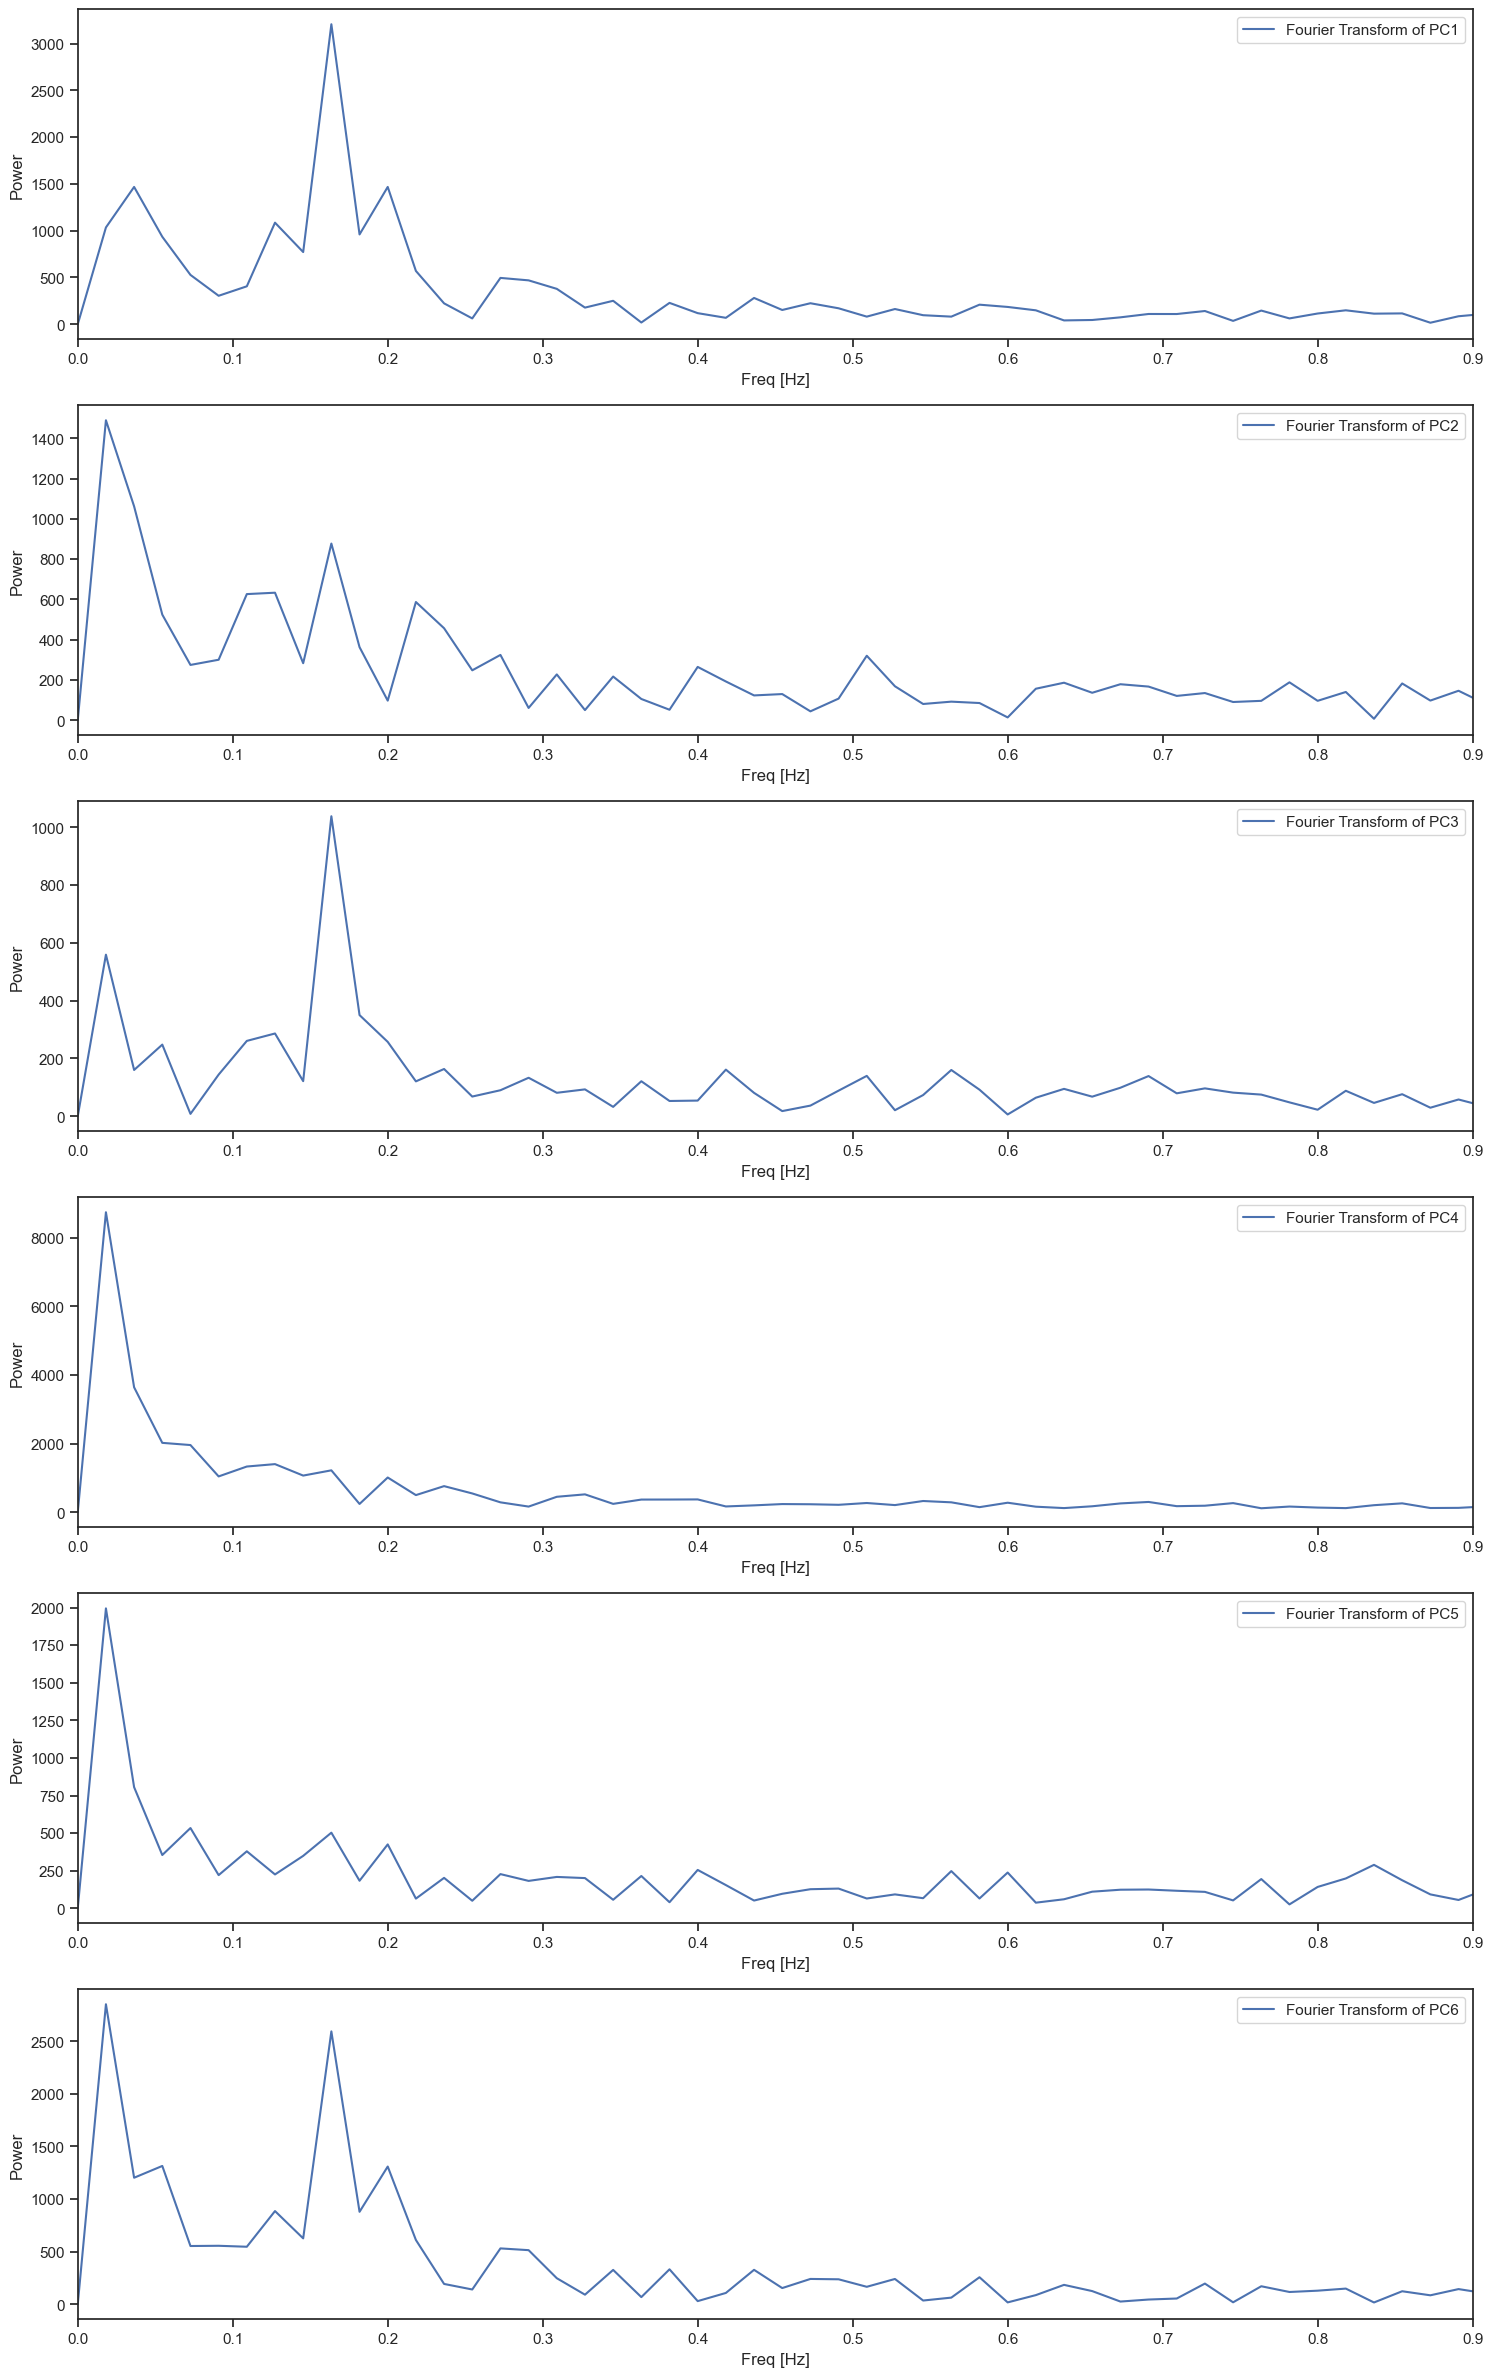

In [15]:
plt.figure(figsize=(18, 5 * N_PCA))
for i in range(N_PCA):
    ax = plt.subplot(N_PCA, 1, i+1)
    plt.plot(sample_freq, np.abs(sig_fft[:, i]), label="Fourier Transform of " + PCA_LABELS[i])
    ax.set_xlim(0, 0.9)
    plt.xticks(np.arange(0, 1, 0.1))
        
    plt.xlabel("Freq [Hz]")
    plt.ylabel("Power")
    plt.legend(loc="best")
    

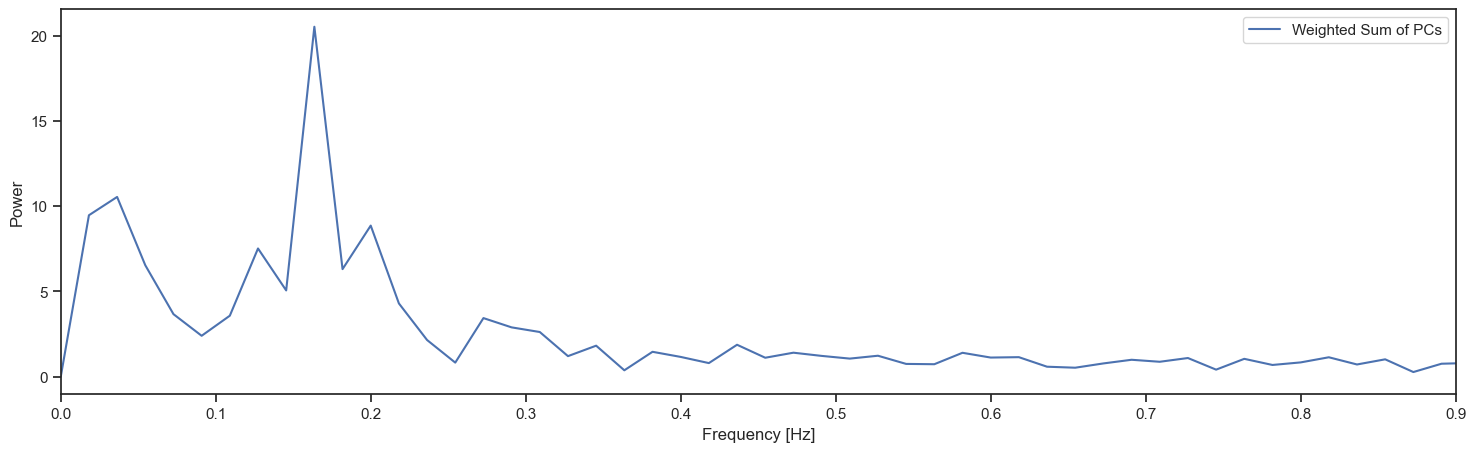

In [43]:
for i in range(N_PCA):
    sig_fft[:, i] *= var_ratios[i] 
total_FFT = np.sum(np.abs(sig_fft), axis=1)
plt.figure(figsize=(18, 5))
plt.plot(sample_freq, total_FFT, label="Weighted Sum of PCs")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.xlim(left=0, right=0.9)
plt.legend();

# Filter

We now apply a filter using a wavelet transform in order to extrapolate only the components of the signal at the desired frequencies.

Wavelet transform is a powerful alternative to Fourier transform, able not only to the frequency nformation of the dataset but also at which moment a particular frequency is present. In this project we used a dyadic tree-level wavelet decomposition via the wavelet "sym5", as it is smooth and allows for a high level of decomposition. In the first level, the signal is split into low- and high-frequency components, that respectively provide the coarser part and the detailed information of the original signal and are thus termed as the approximation and the detail; this first low-frequency subband component is then downsampled by a factor of 2 and again decomposed into low- and high-frequency subbands. This process can be repeated to J levels as desired: in this project we stopped at level 10. The frequency range covered by AJ is $0$ to $f_{s}/2^{J+1}$ Hz and that for Dj is $f_{s}/2^{j+1}$ to $f_{s}/2^{j}$ Hz, where $f_{s}$ represents the sampling frequency (in unit Hz) of the original signal, so 200 Hz in our case.

For this project we want to filter the high frquencies components due to heart beats and noise, and also very low, near-zero frequencies: we will thus reconstruct the time signal using only the coefficients for D10 and D9 which correspond to a range of [0.098, 0.39] Hz.

In [17]:
#Filter signal using wavelets

lvl = 10
if file_name != "center_sternum.txt":
    lvl = 9

coeffs = pywt.wavedec(data_pca[PCA_LABELS], "sym5", level=lvl, axis=0)
#set coefficients related to undesired freuqncies to zero 
coeffs[0] = np.zeros_like(coeffs[0])
for i in range(3, lvl + 1):
    coeffs[i] = np.zeros_like(coeffs[i])

#reconstruct time signal 
filtered_sig = pywt.waverec(coeffs, "sym5", axis=0)

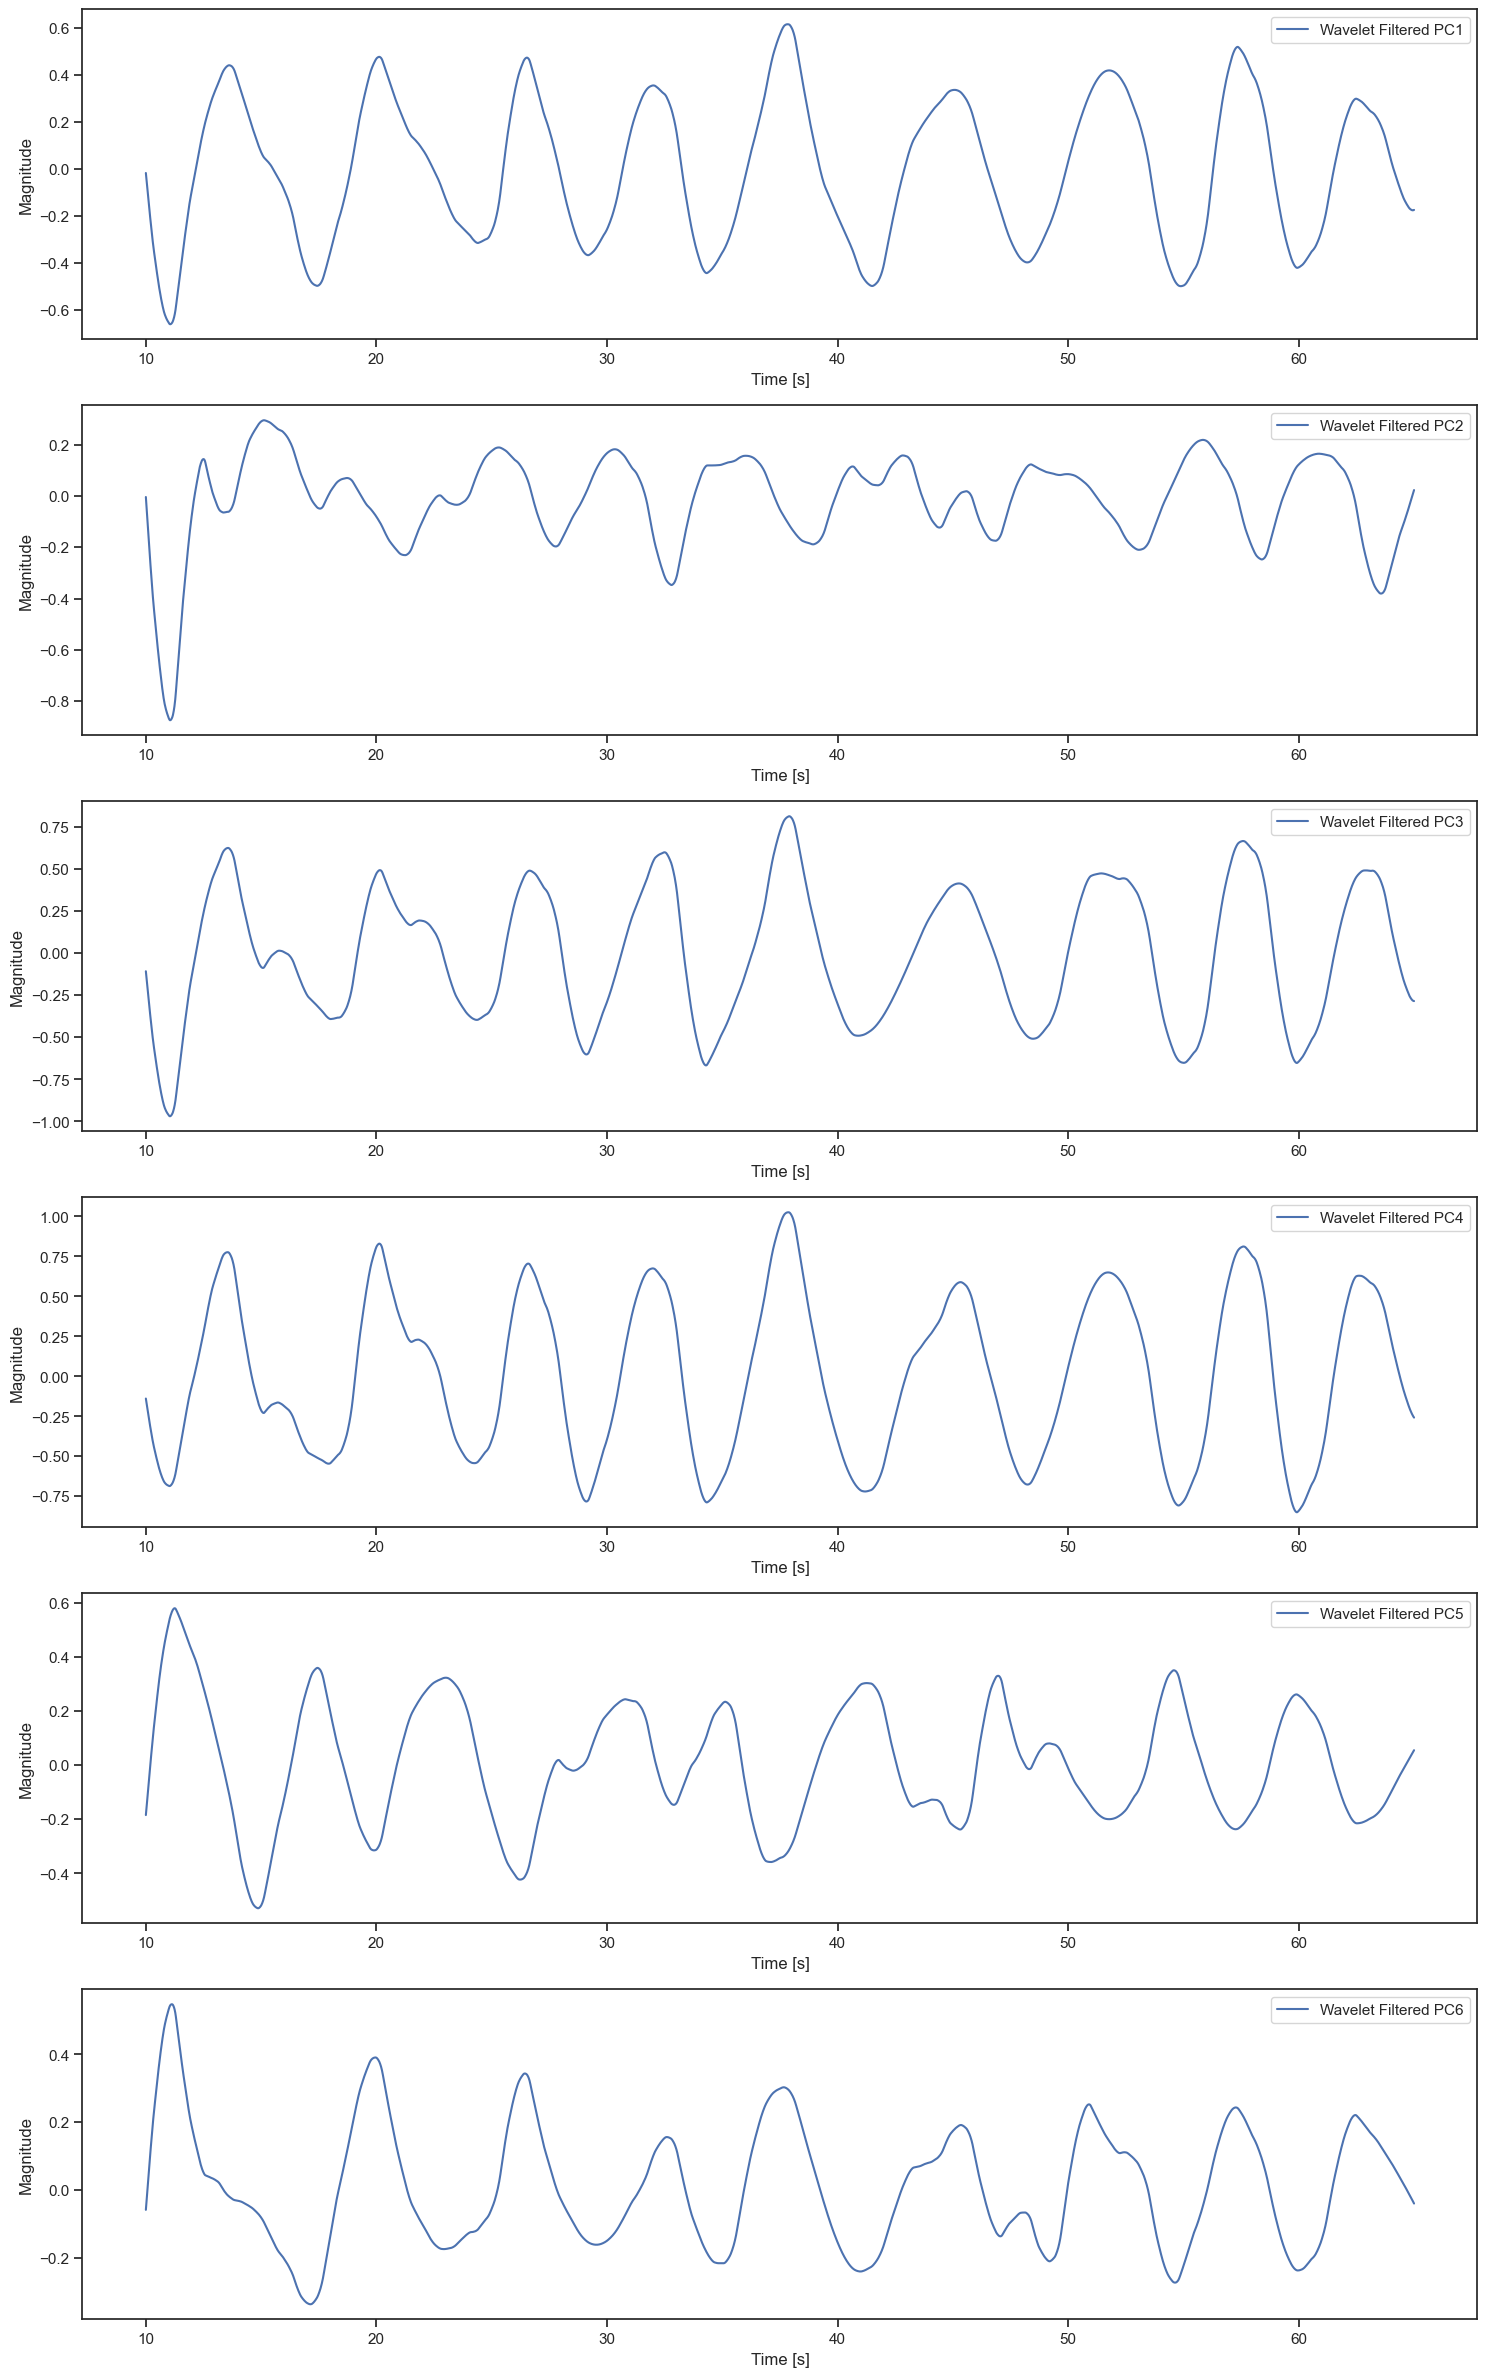

In [18]:
#plot recostructed time signal
fig, axs = plt.subplots(nrows=N_PCA, ncols=1, figsize=(18, N_PCA*5))

for i in range(N_PCA):
    axs[i].plot(data_pca["Abs Time"], filtered_sig[:-1, i], label=("Wavelet Filtered "+PCA_LABELS[i]))
        
    axs[i].set_xlabel("Time [s]")
    axs[i].set_ylabel("Magnitude") # ???
    axs[i].legend(loc="best")
    

We will now quickly repeat a Fourier analysis in order to show that indeed only the desired frequencies are kept after the filter.

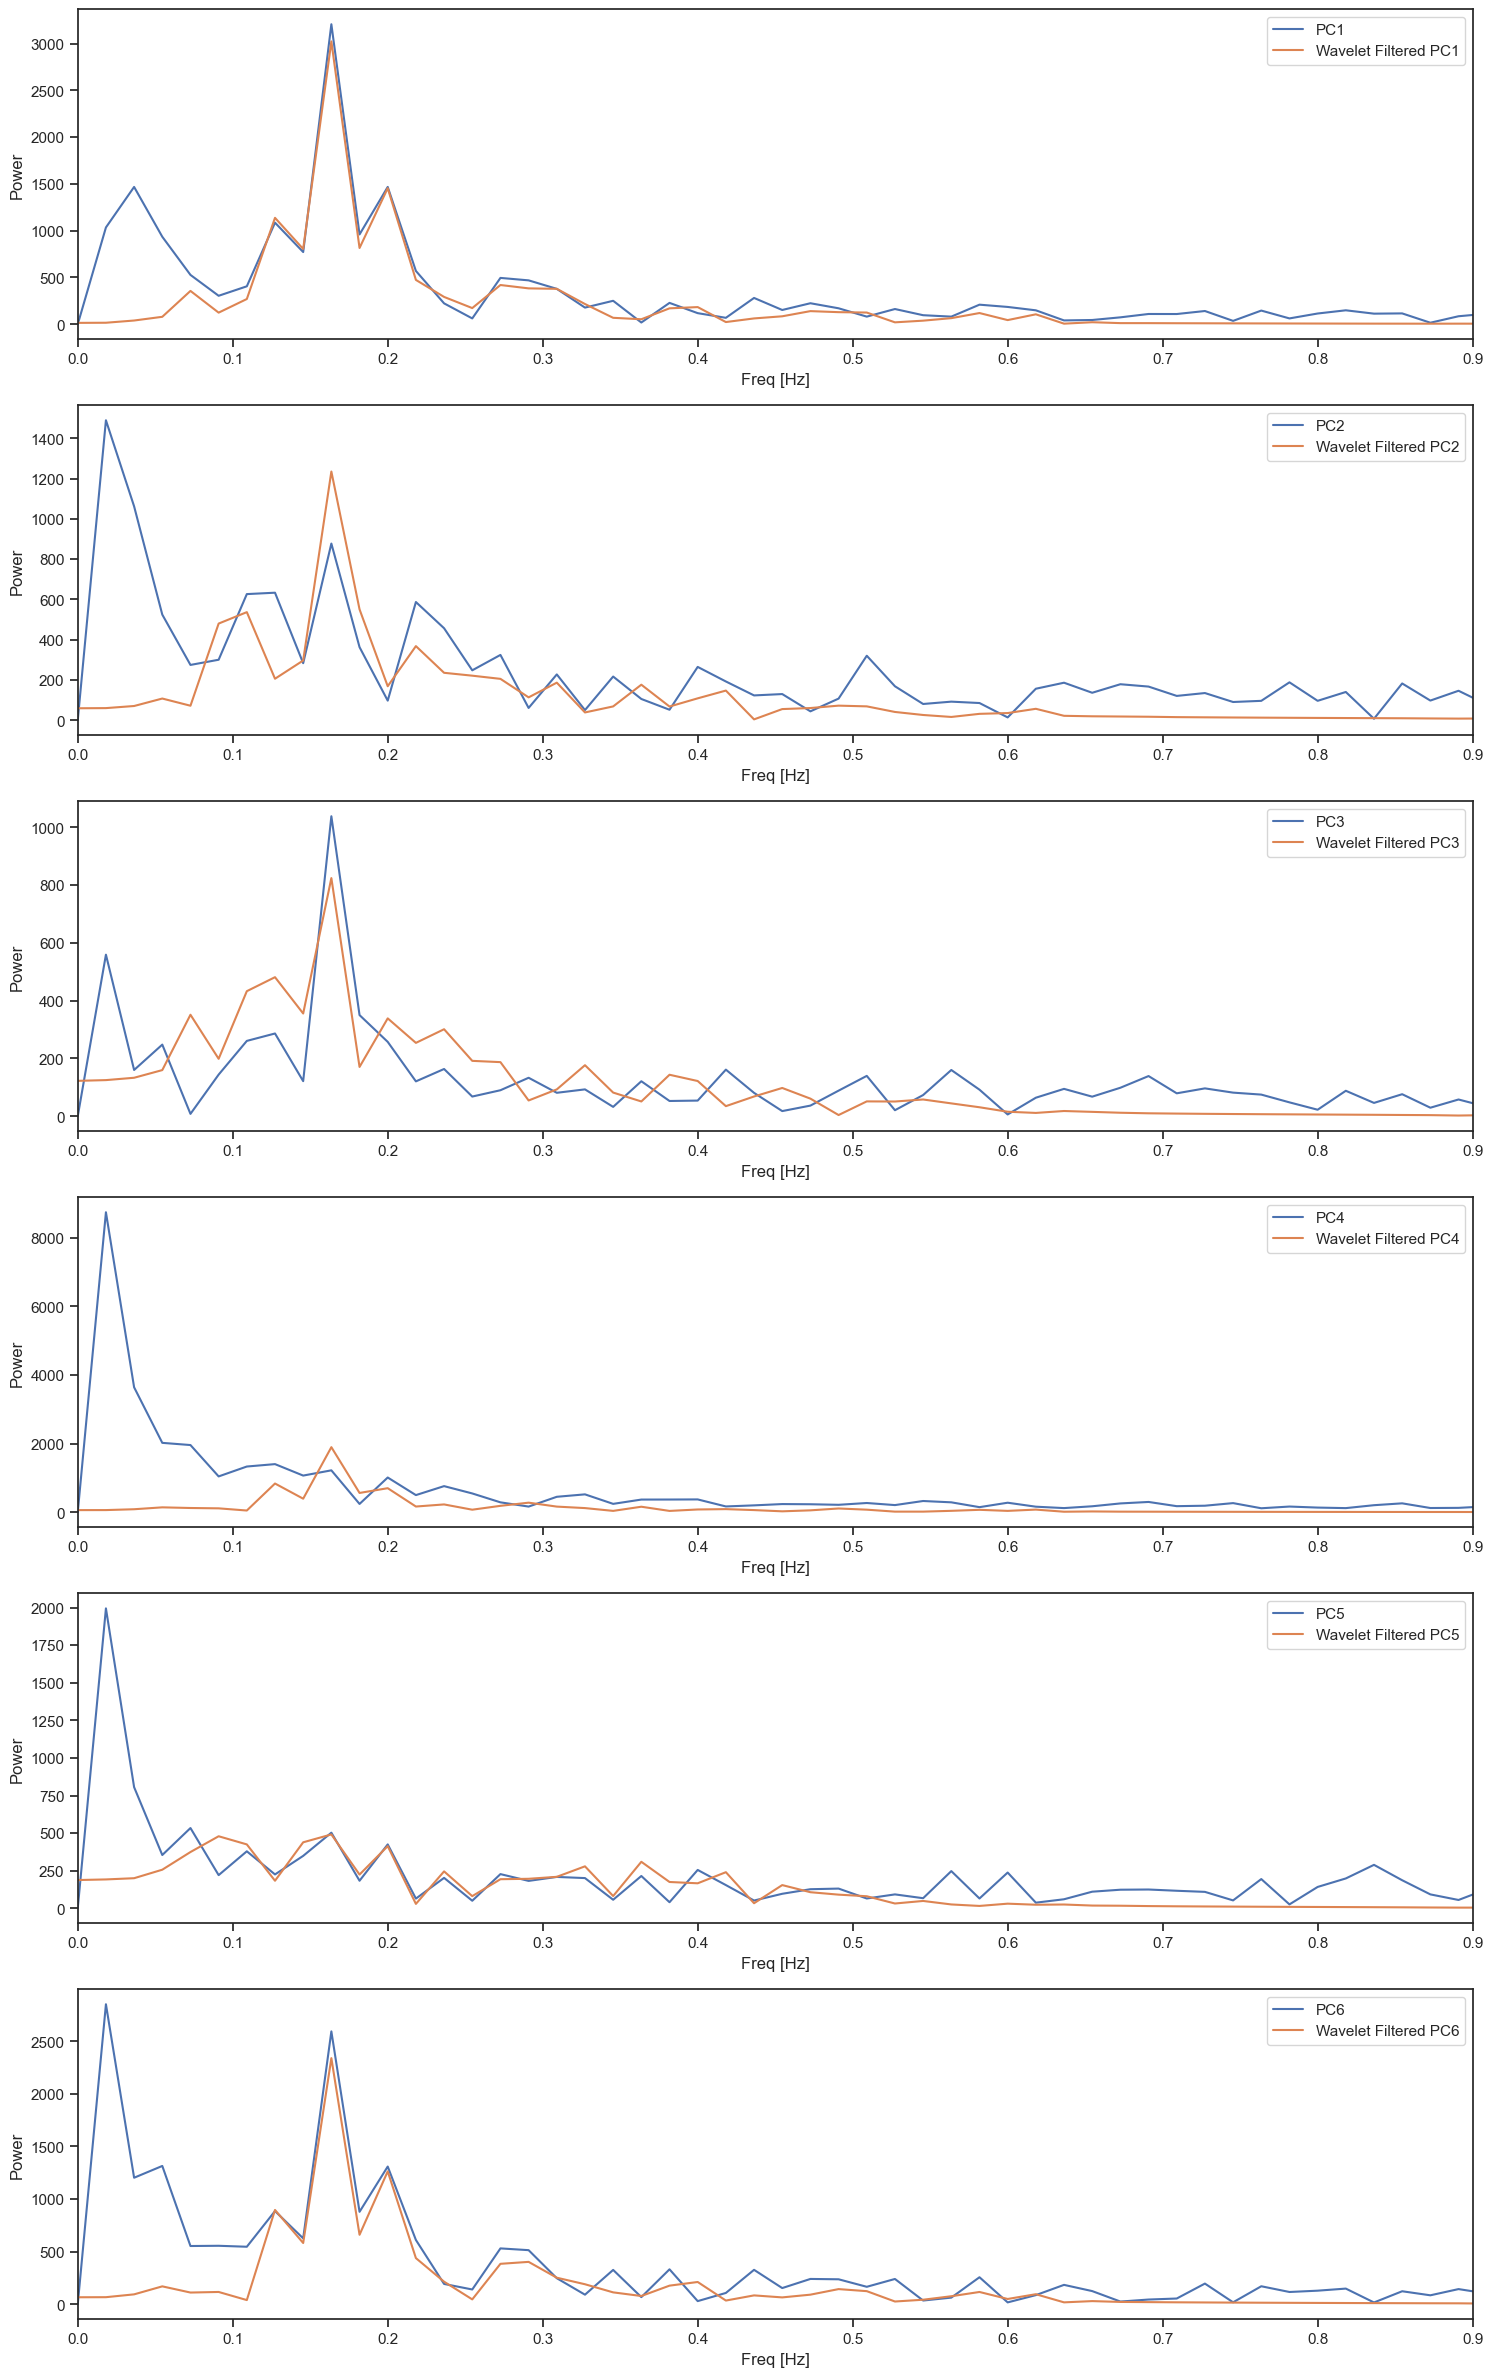

In [19]:
sig_fft_wt = fft.fftshift(fft.fft(filtered_sig[:-1, :], axis=0))
sample_freq = fft.fftshift(fft.fftfreq(len(data_pca), d=1/ACQ_FREQ))

plt.figure(figsize=(18, 5 * N_PCA))
for i in range(N_PCA):
    ax = plt.subplot(N_PCA, 1, i+1)
    plt.plot(sample_freq, np.abs(sig_fft[:, i]), label=PCA_LABELS[i])
    plt.plot(sample_freq, np.abs(sig_fft_wt[:, i]),
             label="Wavelet Filtered " + PCA_LABELS[i])
    ax.set_xlim(0, 0.9)
    plt.xticks(np.arange(0, 1, 0.1))
        
    plt.xlabel("Freq [Hz]")
    plt.ylabel("Power")
    plt.legend(loc="best")
    

# Metrics

### Peak Detection

After having filtered our signals we are ready to extract the **Respiratory Rate (RR)** and the **Respiratory Rate Variability (RRV)** from them. The idea is to spot the peaks of our signals, in order to compute the difference of their correspondent consecutive abscissa: this allows us to collect a sample of periods $T_i$ that can be further elaborated to estimate RR and RRV. To do so we start by naively using the find_peaks function of Scipy on each of our filtered PC signals. However, find_peaks, if used without appropriate parameters, returns raw peaks that do not reflect properly the periodicity of the signals, as it will be evident from the example plot below.

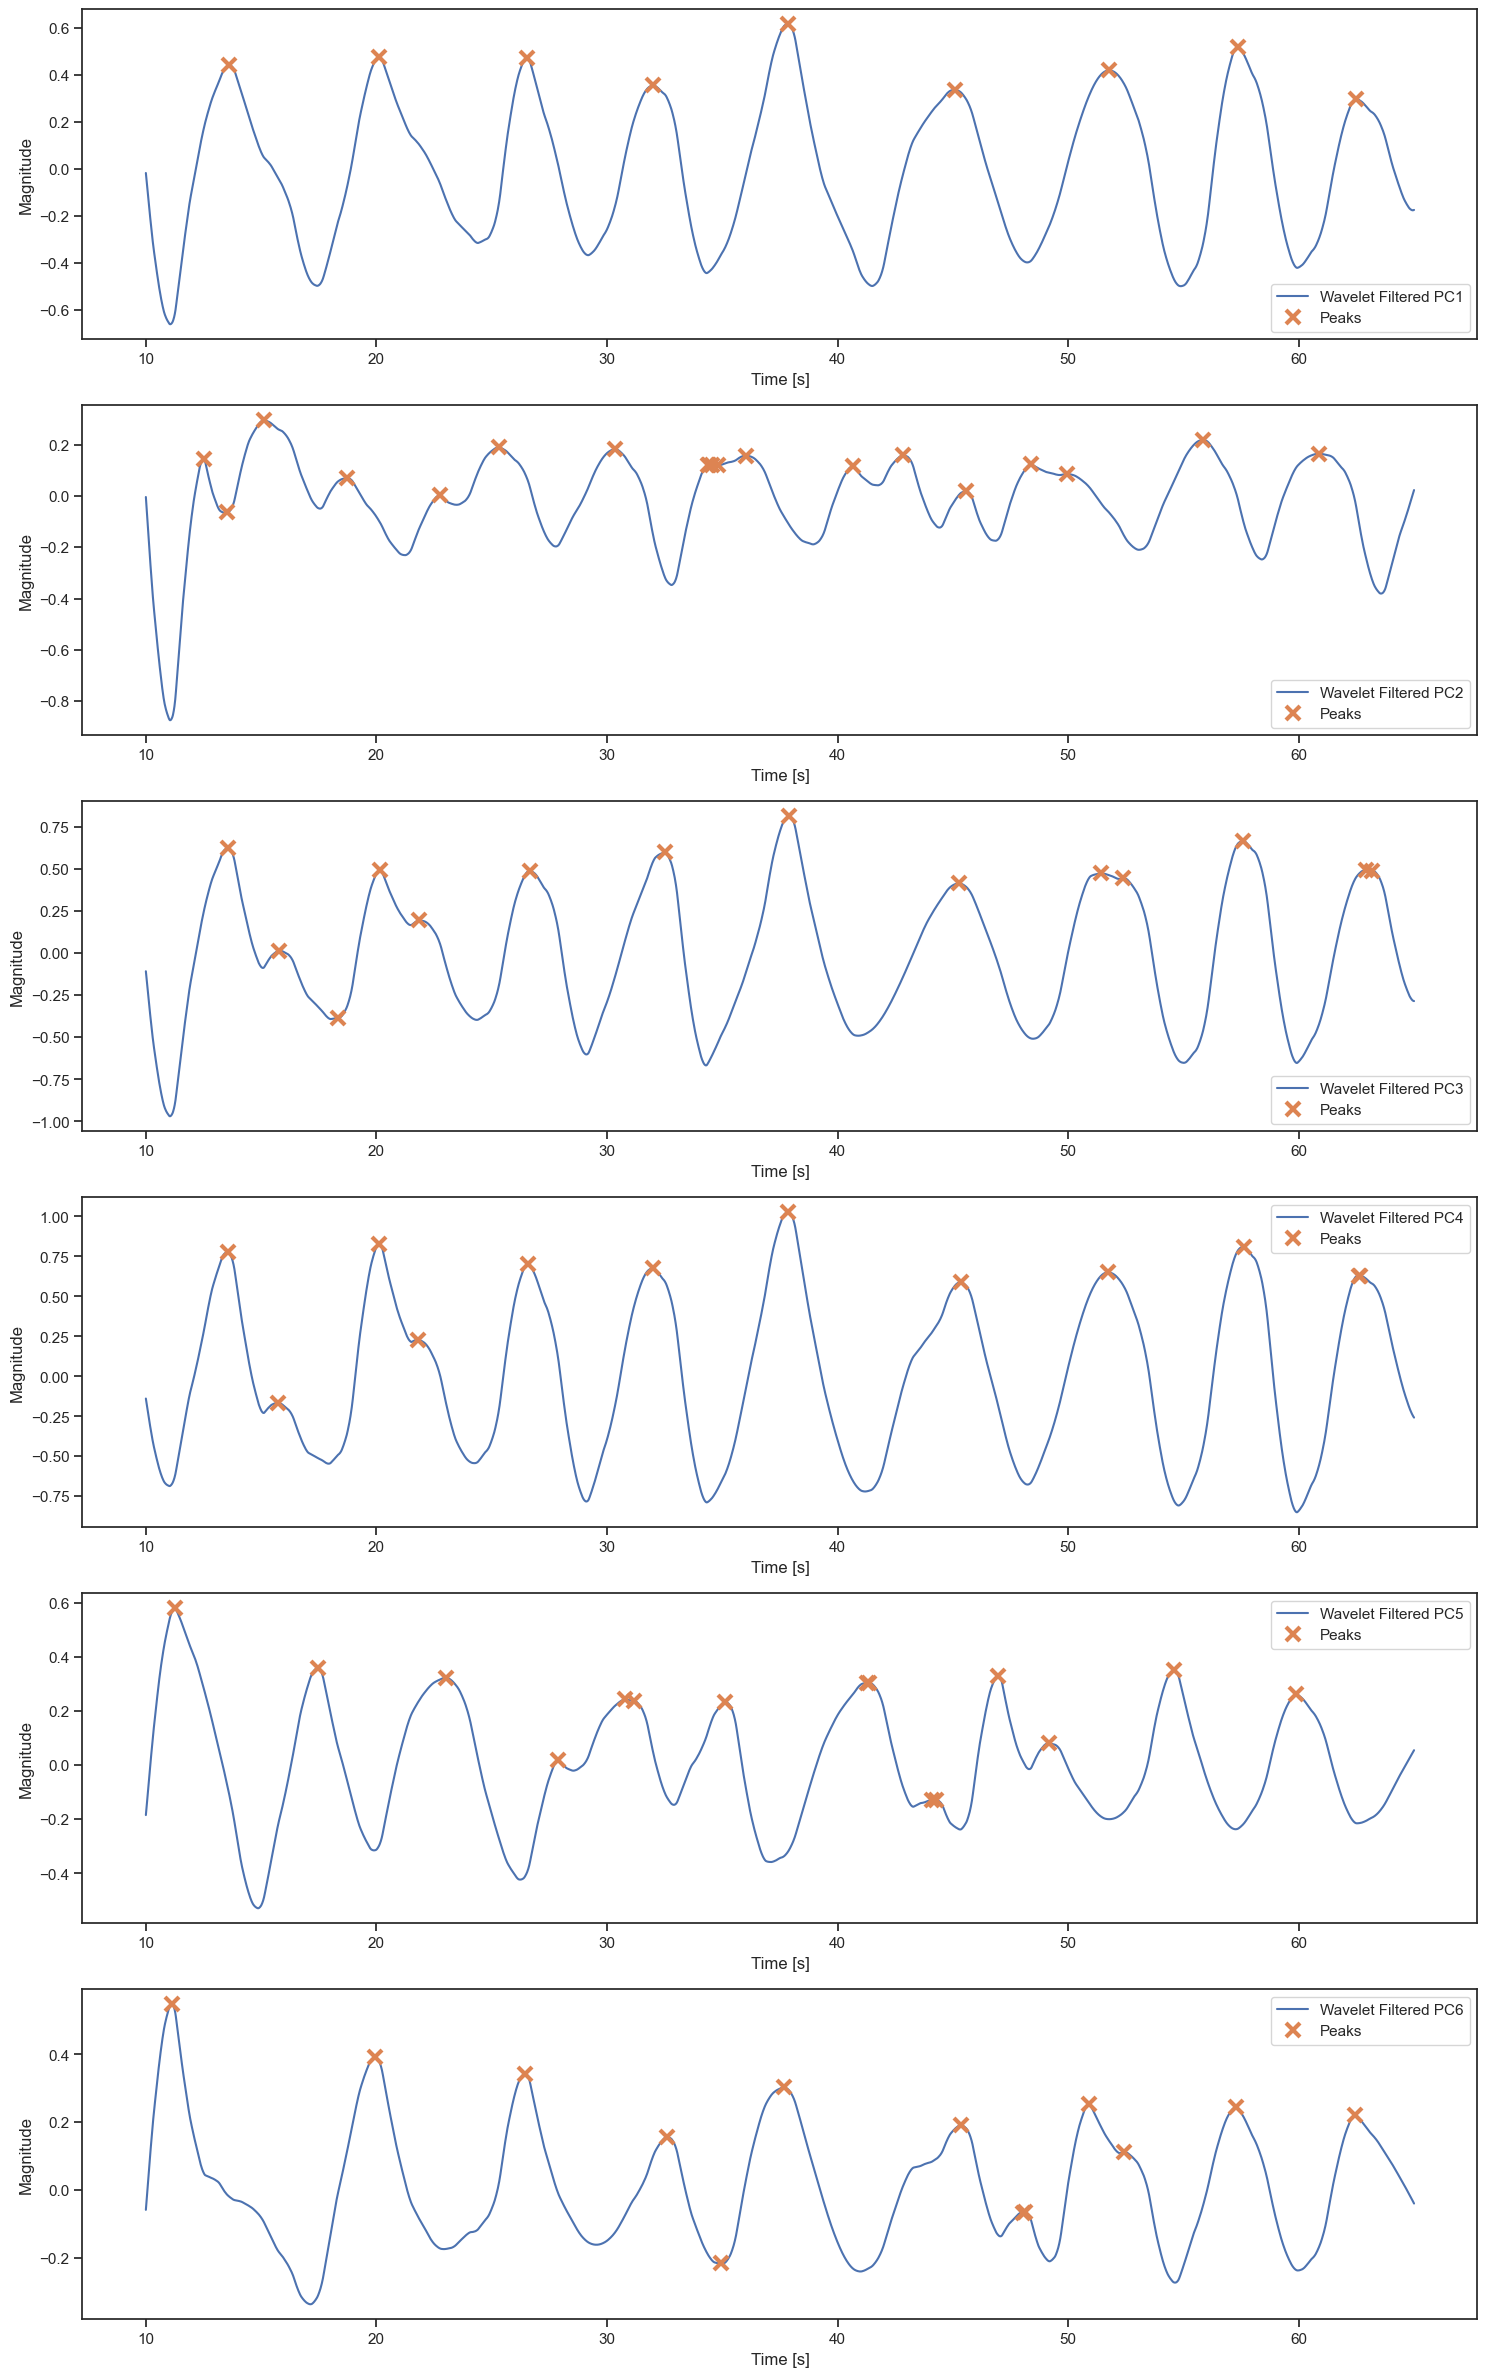

In [32]:
filtered_sig=filtered_sig.T

peaks = []
valleys = []
for i in range(len(filtered_sig)):
    temp_signal = filtered_sig[i][:-1]
    temp_peaks, _ = signal.find_peaks(temp_signal)
    temp_valleys, _ = signal.find_peaks(-temp_signal)
    peaks.append(temp_signal[temp_peaks])
    peaks.append(data_std['Abs Time'].values[temp_peaks])
    valleys.append(temp_signal[temp_valleys])
    valleys.append(data_std['Abs Time'].values[temp_valleys])
    
fig, ax = plt.subplots(len(filtered_sig), 1, figsize=(18, 5 * N_PCA))
for i in range(len(peaks) // 2):    
    ax[i].plot(data_std['Abs Time'], filtered_sig[i][:-1], label="Wavelet Filtered "+PCA_LABELS[i])
    ax[i].plot(peaks[i * 2 + 1], peaks[i * 2], 'x', label="Peaks", markersize=10, markeredgewidth=3)
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("Magnitude")
    ax[i].legend(loc="best")

### Improving Peak Detection

In order to improve the detection of the peaks we run again the code, paying attention to properly setting the parameters *height* and *distance* of the function find peaks. The former sets an height level that each sample must reach in order to be potentially recognized as a peak, and it has been set equal to the 70% of the mean value of the middle height between a maxima and the subsequent minima. The latter sets a minimum sample distance that needs to occur between subsequent peaks, and has been set equal to the 70% of the mean peak distance. In both cases we have set the 70% of the two quantities so as to preserve the variability of the $T_i$, otherwise small $T_i$ values would have been excessively penalized with respect to larger ones.

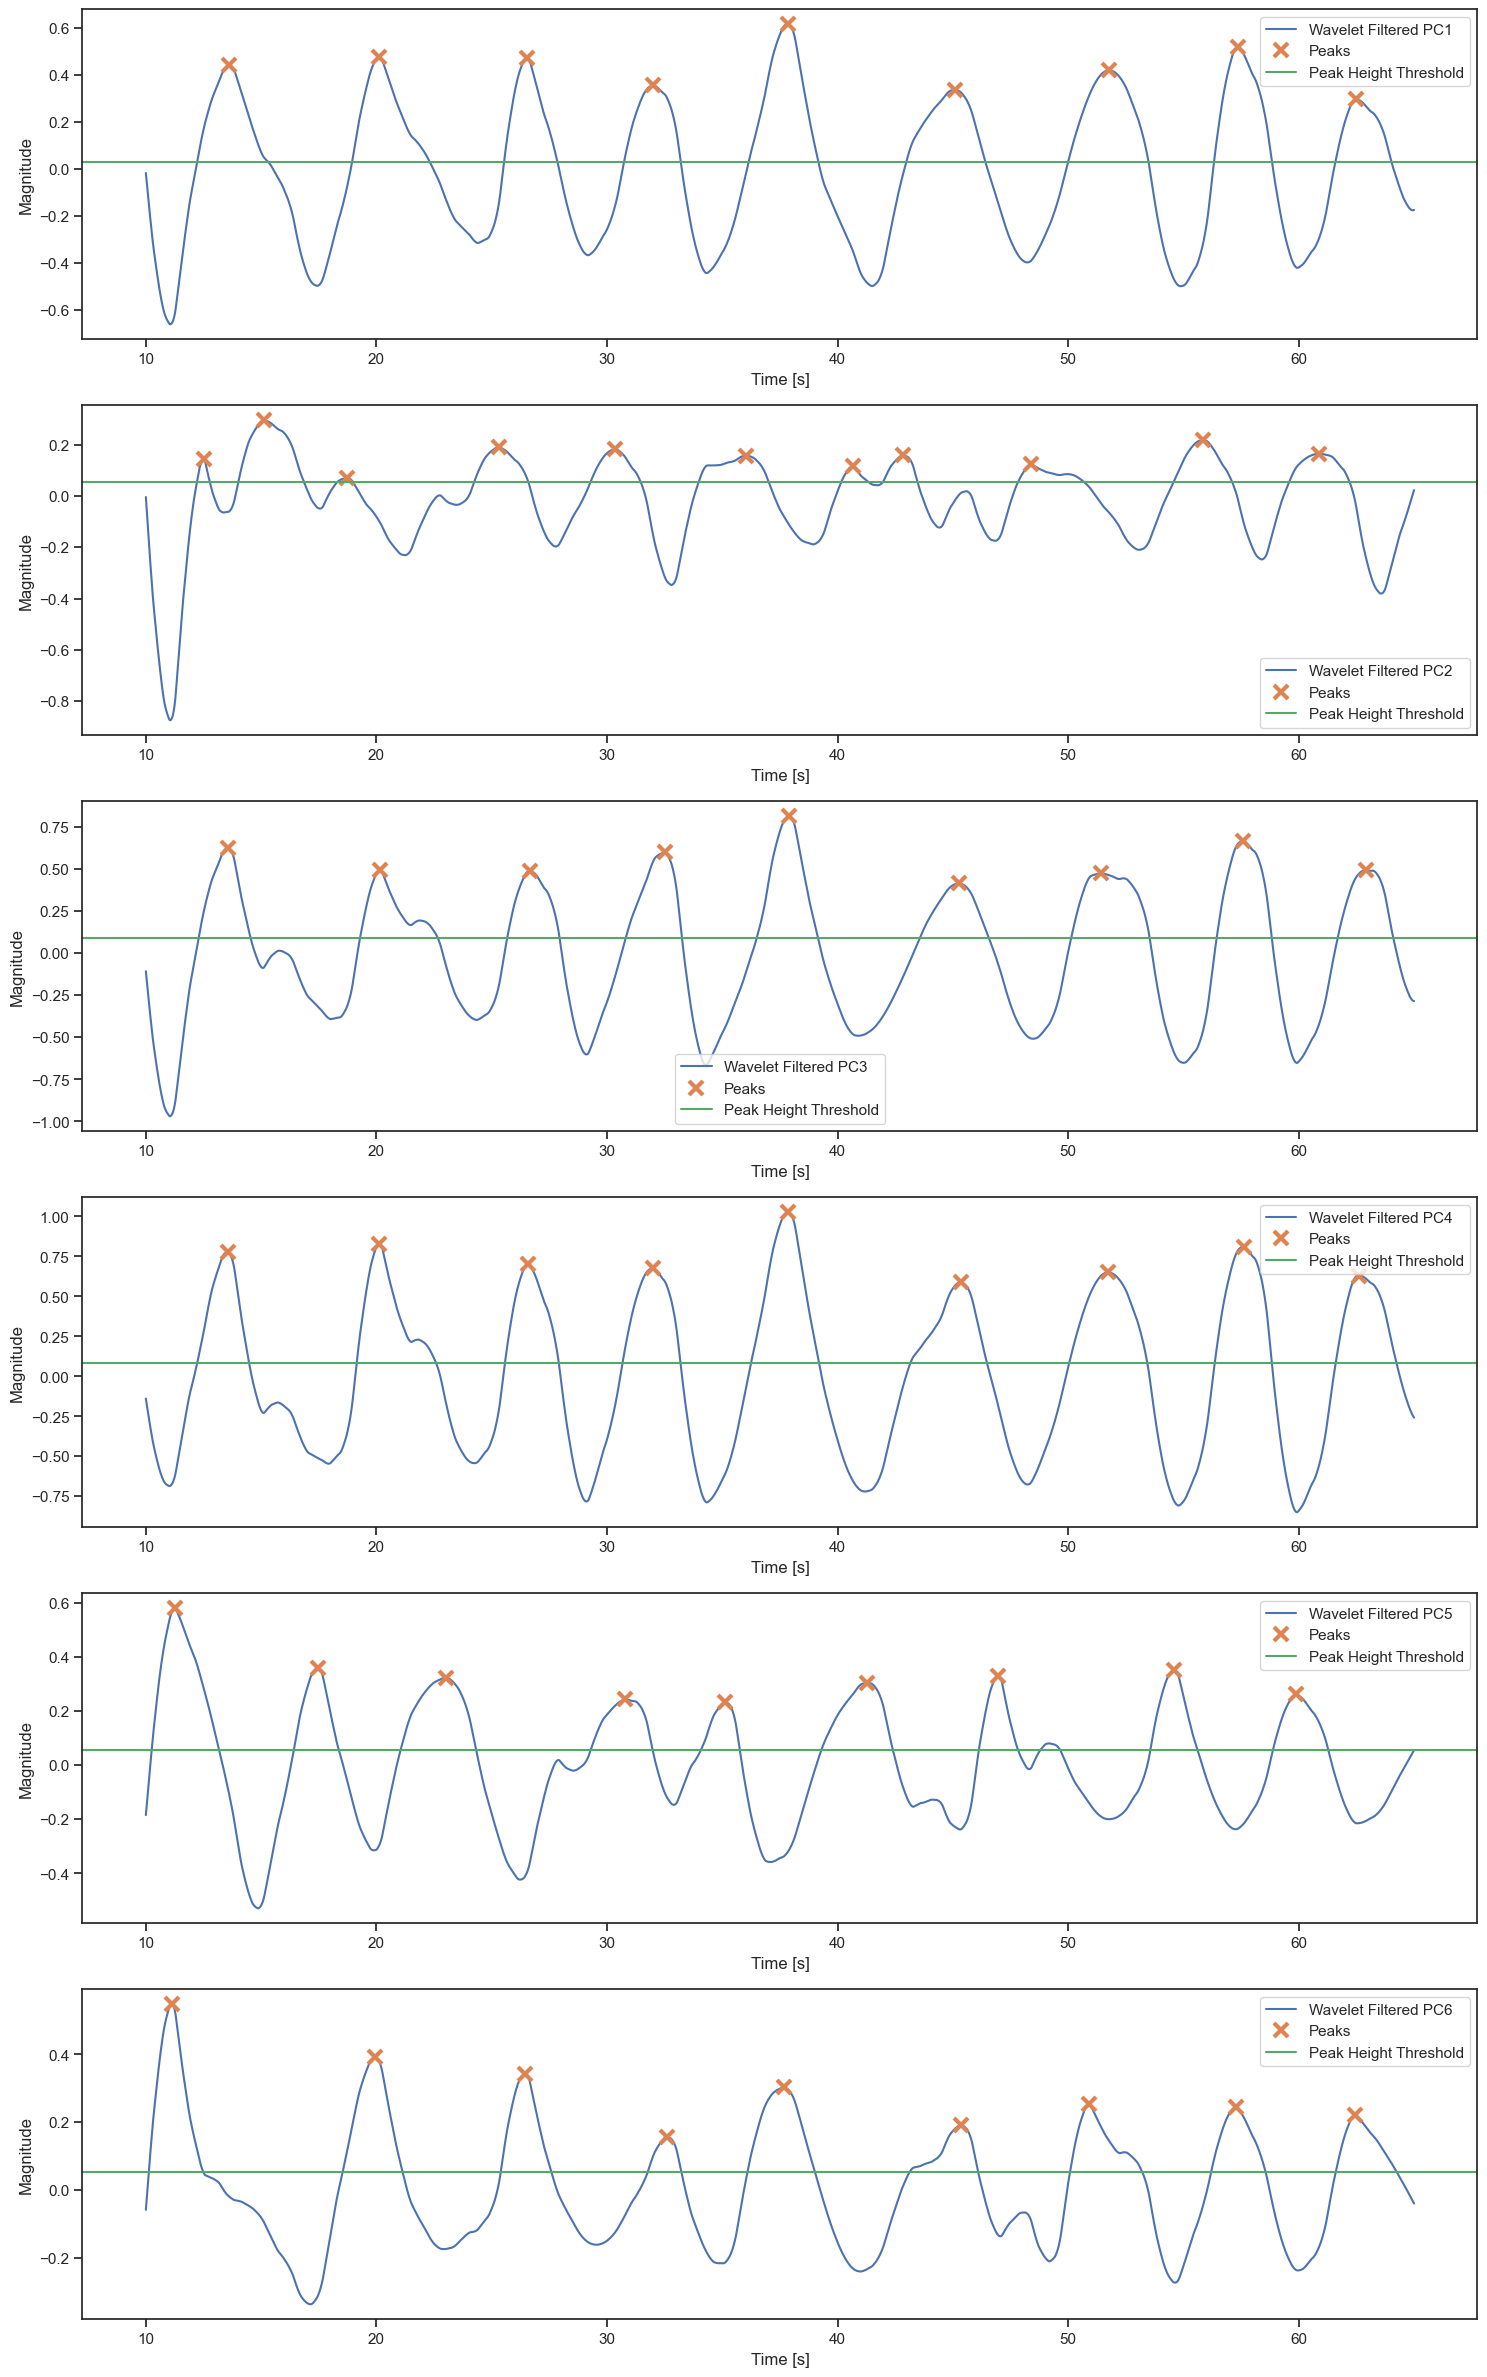

In [21]:
avg_peak_dist = []
for i in range(1, len(peaks), 2):    
    avg_peak_dist.append(len(data_std['Abs Time']) / len(peaks[i]))

sign_amp = []
for i in range(1, len(peaks), 2):
    temp_sign_amp = []    
    for j in range(np.min([len(peaks[i]), len(valleys[i])])):
        temp_peaks = np.array(peaks[i-1])
        temp_valleys = np.array(valleys[i-1])
        temp_sign_amp.append(0.5*np.abs(temp_peaks[j] + temp_valleys[j]))
    sign_amp.append(temp_sign_amp)

avg_sign_amp = np.empty(shape=(len(filtered_sig)))
for i,x  in enumerate(sign_amp):
    avg_sign_amp[i] = np.mean(x)

height_perc = .6
distance_perc = .7
peaks_refined = []
valleys_refined = []
for i in range(len(filtered_sig)):
    temp_signal = filtered_sig[i][:-1]
    temp_peaks, _ = signal.find_peaks(temp_signal, height = height_perc * avg_sign_amp[i], distance = distance_perc * avg_peak_dist[i])
    temp_valleys, _ = signal.find_peaks(-temp_signal)
    peaks_refined.append(temp_signal[temp_peaks])
    peaks_refined.append(data_std['Abs Time'].values[temp_peaks])
    valleys_refined.append(temp_signal[temp_valleys])
    valleys_refined.append(data_std['Abs Time'].values[temp_valleys])

fig, ax = plt.subplots(len(filtered_sig), 1, figsize=(18, 5 * N_PCA))
for i in range(len(peaks_refined) // 2):    
    ax[i].plot(data_std['Abs Time'], filtered_sig[i][:-1], label="Wavelet Filtered "+PCA_LABELS[i])
    ax[i].plot(peaks_refined[i * 2 + 1], peaks_refined[i * 2], 'x', label="Peaks", markersize=10, markeredgewidth=3)
    ax[i].axhline(avg_sign_amp[i] * height_perc, color='g', label="Peak Height Threshold")
    ax[i].legend(loc="best")

    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("Magnitude")
    ax[i].legend(loc="best")

### Generate Histogram and Estimate Respiratory Rate

After detecting the peaks, the sample of $T_i$ is generated, plotted in an histogram and fitted with a gaussian function in order to estimate the Respiration Rate. 

The set of the T_i contains 50 samples.
Fit parameters (Amplitude, Mean, Sigma): [2.11484745 5.97782287 0.87568315]
Fit parameters errors (Amplitude, Mean, Sigma): [0.80229953 0.3835868  0.38362935]
The estimated Respiratory Period is 5.98 s, corresponding to a Respiratory Rate of 0.17 Hz, i.e. approximately 10.0 breaths per minute.


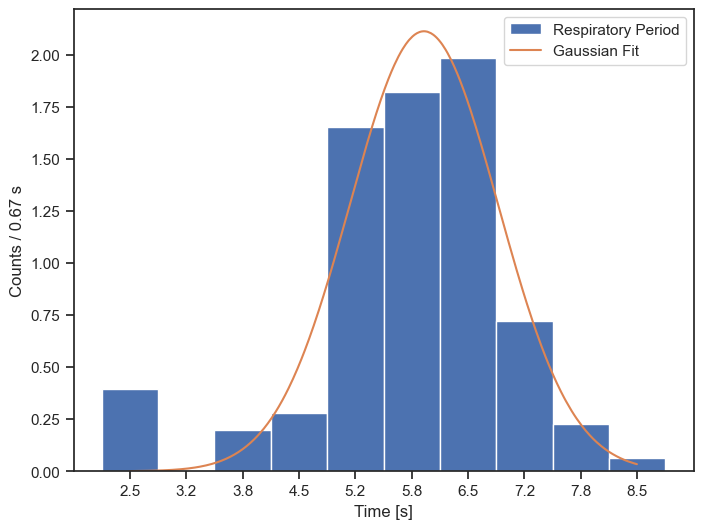

In [22]:
time_dist = []
for i in range(1, len(peaks_refined), 2):
    temp_time_dist = []    
    for j in range(1, len(peaks_refined[i])):
        temp_peaks_time = peaks_refined[i]
        temp_time_dist.append(temp_peaks_time[j]-temp_peaks_time[j-1])
    time_dist.append(temp_time_dist)

weights = [[var_ratios[i] for j in range(len(time_dist[i]))] for i in range(N_PCA)]

time_dist_total = np.concatenate(time_dist)
weights_total = np.concatenate(weights)
print(f'The set of the T_i contains {len(time_dist_total)} samples.')

fig, ax = plt.subplots(figsize=(8,6))
bins = ax.hist(x=time_dist_total, label="Respiratory Period", weights=weights_total)

bin_centers = (bins[1][:-1] + bins[1][1:]) / 2
bin_counts = bins[0]
bin_width = round(bins[1][1]-bins[1][0], 2)

def myround(x):
    return round(x,1)

ax.set_xticks(bin_centers)
ax.set_xticklabels(map(myround,bin_centers))

def my_gaus(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x-mu)/sigma) ** 2)

params, params_cov = optimize.curve_fit(my_gaus, bin_centers, bin_counts, p0=[1, np.mean(time_dist_total), np.std(time_dist_total)], absolute_sigma=True, bounds=(0,[100, 100, 100]))
fit_domain = np.sort(np.random.uniform(np.min(bin_centers), np.max(bin_centers), 1000))
ax.plot(fit_domain, my_gaus(fit_domain, *params), label="Gaussian Fit")
plt.xlabel("Time [s]")
plt.ylabel(f"Counts / {bin_width} s")
plt.legend()

print('Fit parameters (Amplitude, Mean, Sigma):',params)
print('Fit parameters errors (Amplitude, Mean, Sigma):', np.sqrt(np.diag(params_cov)))
print(f'The estimated Respiratory Period is {params[1]:.2f} s, corresponding to a Respiratory Rate of {1 / params[1]:.2f} Hz, i.e. approximately {60 / params[1]:.1f} breaths per minute.')

### Respiratory Rate Variability

Now that we got an estimate of the Respiratory Rate, we need an appropriate quantity that measures its variability. As we have found [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8339683/), there are many quantities that are used to estimate Respiratory Rate Variability, according to the specific setup one is working on. A common RRV parameter used in the case of quantitative time series analysis is root mean square of successive differences (RMSSD), defined as 
$$
\text{RMSSD}(\vec{x}) = \sqrt{\frac{1}{N}\sum_{i=2}^{N}|x_i - x_{i-1}|^2}
$$
where the vector $\vec{x}$ represents the set of $T_i$. However, to include in this calculation the information coming from the previous PCA, we decided to perform the weighted mean of the RMSSD of each selected PC, with the weights taken as the variability ratios of each PC. The equation becomes
$$
\text{RMSSD}(\vec{x}) = \frac{1}{\sum_{\text{selected PCs}} w_{PC}} \sum_{\text{selected PCs}} \sqrt{\frac{1}{N_{PC}}\sum_{i=2}^{N_{PC}} |x_i - x_{i-1}|^2} \cdot w_{PC}
$$

In [23]:
RRVs_sq = np.zeros(shape=len(time_dist))
for i, x in enumerate(time_dist):
    x = np.array(x)
    RRVs_sq[i] = np.sqrt(np.mean(np.diff(x) ** 2))

RRV = np.average(RRVs_sq, weights=var_ratios[:N_PCA])
print(f'The Respiratory Variability Rate is {RRV:.2f} s.')

The Respiratory Variability Rate is 1.34 s.


**Alternative method without filter**

When we have no filter we can consider the frequencies' range [0.1,0.4] and compute the respiration rate as the mean of the frequencies of the three max power in the fourier analysis for each of the six principal components

In [24]:
mask = (sample_freq > 0.1) & (sample_freq < 0.4)
power_fft = np.abs(sig_fft)

freqi_maxs = np.argmax(power_fft[mask, :], axis=0)
freq_maxs = sample_freq[mask][freqi_maxs]
RR = np.mean(freq_maxs)

print(f"Respiratory Rate Per Minute is: {RR * 60:.2f}")

Respiratory Rate Per Minute is: 9.45


# Conclusions

## EXTRA

### Time Signal

Let us plot the features as a function of time individually, zooming in a restricted time window to highlight their trend. 

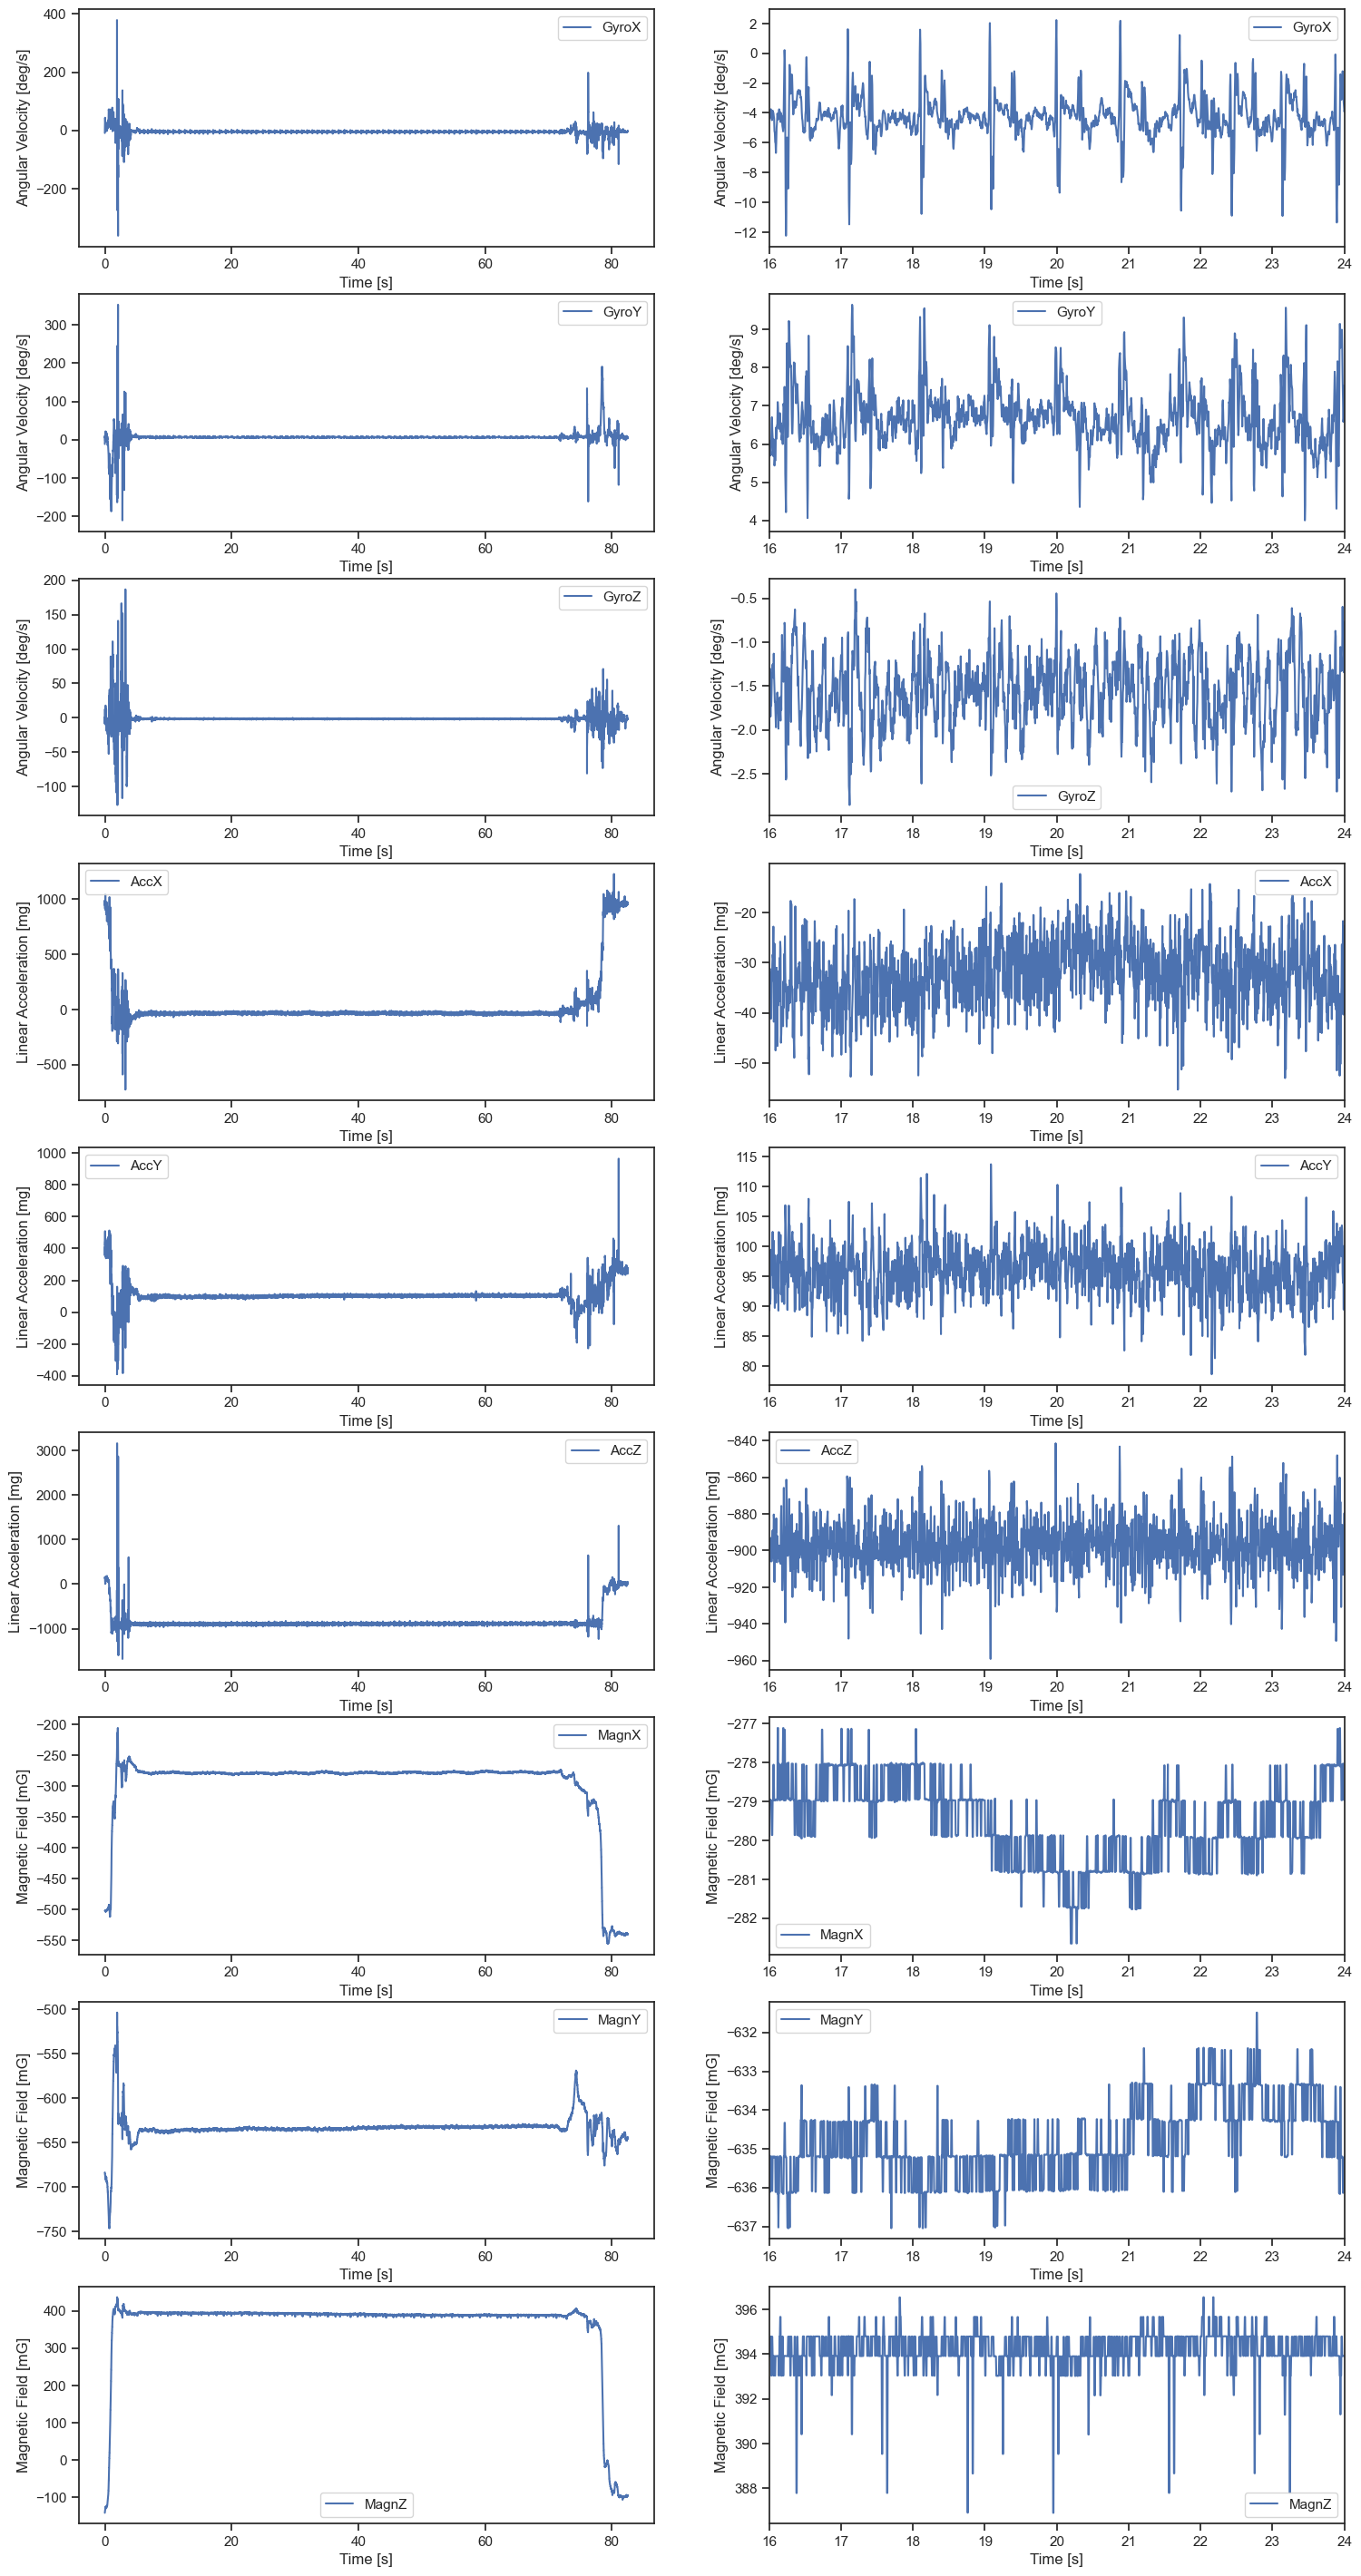

In [33]:
fig, axs = plt.subplots(Nvar, 2, figsize=(18, 4 * Nvar))
for i in range(2):
    for j in range(Nvar):
        if i == 0:
            x_range = raw_data["Abs Time"]
            data_range = raw_data[labels[j]]
        else:
            xmax, xmin = 16, 24
            ixmin, ixmax = (xmax * ACQ_FREQ - 50,  xmin * ACQ_FREQ + 50)
            data_range = raw_data.loc[ixmin:ixmax ,labels[j]]
            x_range = raw_data.loc[ixmin:ixmax, "Abs Time"]
            axs[j][i].set_xlim(xmax, xmin)

        axs[j][i].plot(x_range, data_range, label=labels[j]) #c='b' ?
        axs[j][i].set_xlabel("Time [s]")

        if "Acc" in labels[j]:
            axs[j][i].set_ylabel("Linear Acceleration [mg]")
        elif "Gyro" in labels[j]:
            axs[j][i].set_ylabel("Angular Velocity [deg/s]")
        elif "Magn" in labels[j]:
            axs[j][i].set_ylabel("Magnetic Field [mG]")

        axs[j][i].legend(loc="best")

### Different Types of Filter

We tried different types of filters to find out which one worked best for our purposes.

First, we implemente a simple Butterworth filter in the range [0.1, 0.4] Hz, which has the merit of not having any ripple in the passband (at the expense of rolling slowly towards zero in the stopband).

In [25]:
FREQ_RANGE = (0.1, 0.4)

sos = signal.butter(4, FREQ_RANGE, 'bandpass', fs=ACQ_FREQ, output='sos')
filtered_butter = signal.sosfilt(sos, data_pca[PCA_LABELS], axis=0)

We then try to better this result by constructing a filter pipeline, consisting of a wavelet filter, so as to keep time related information, followed by the previous Butterworth filter. In this case we adopt Daubechies 6 wavelets (db6), as they are smooth and their shape is similar to the shape of heartbeat and respiration pattern buried in SCG. Unfortunately, their maximum decomposition level is smaller than that of sym5 wavelets, so we cannot filter as precisely as above; we thus decompose up to level 8 and keep the respective approximation coefficients to reconstruct the time signal, therefore keeping frequencies in the [0, 0.39] Hz range. This method has the downside of keeping very low frequencies, but this problem is remedied by the following Butterworth filter.

In [26]:
#Filter signal using wavelets
lvl = 8
if file_name != "center_sternum.txt":
    lvl = 7
    
coeffs = pywt.wavedec(data_pca[PCA_LABELS], "db6", level=lvl, axis=0)

#set coefficients related to undesired frequencies to zero 
for i in range(1, lvl + 1):
    coeffs[i] = np.zeros_like(coeffs[i])

#reconstruct time signal 
filtered_wt = pywt.waverec(coeffs, "db6", axis=0)

#Apply Butterworth filter
filtered_wtb = signal.sosfilt(sos, filtered_wt, axis=0)

To check whether all filters act as expected, let us plot as an example the power spectrum of the second principal component. In all three cases, the peaks around 0.2 Hz are kept while low and high frequencies are eliminated, as expected.

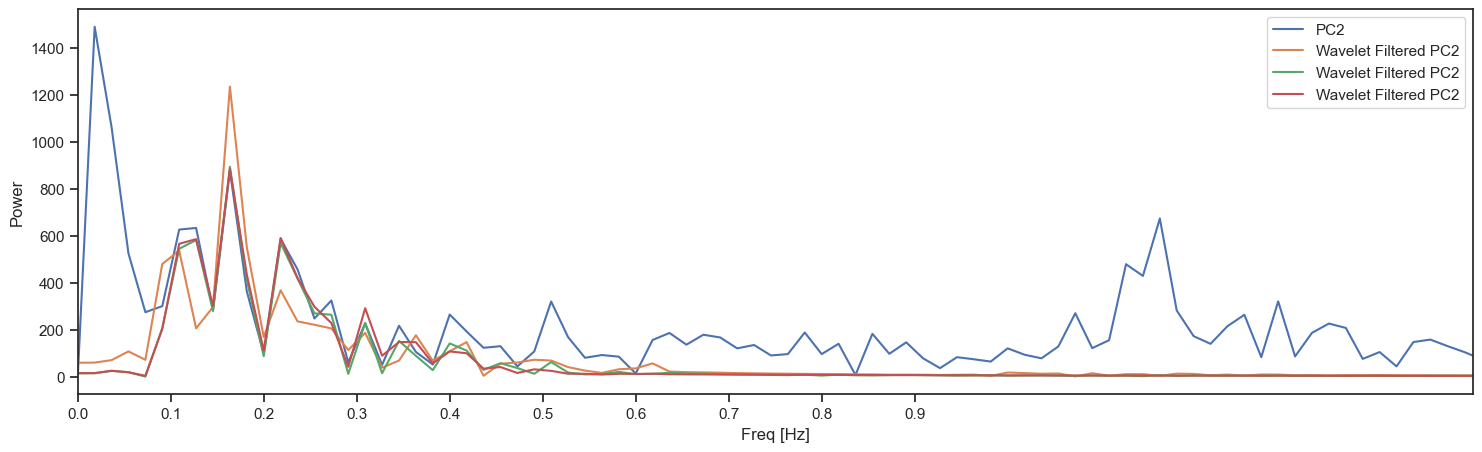

In [27]:
sig_fft_wtb = fft.fftshift(fft.fft(filtered_wtb[:-1, :], axis=0))
sig_fft_butter = fft.fftshift(fft.fft(filtered_butter, axis=0))

plt.figure(figsize=(18, 5))
ax = plt.subplot(1, 1, 1)
plt.plot(sample_freq, np.abs(sig_fft[:, 1]), label=PCA_LABELS[1])
plt.plot(sample_freq, np.abs(sig_fft_wt[:, 1]),
             label="Wavelet Filtered " + PCA_LABELS[1])
plt.plot(sample_freq, np.abs(sig_fft_butter[:, 1]),
             label="Wavelet Filtered " + PCA_LABELS[1])
plt.plot(sample_freq, np.abs(sig_fft_wtb[:, 1]),
             label="Wavelet Filtered " + PCA_LABELS[1])

ax.set_xlim(0, 1.5)
plt.xticks(np.arange(0, 1, 0.1))
        
plt.xlabel("Freq [Hz]")
plt.ylabel("Power")
plt.legend(loc="best")

Now let us plot the reconstructed time signals using the filters just discussed and the one employed in the main analysis, in order to compare the reults; we also plot the original signal (rescaled by factor 2 for purely graphical reasons). 

We observe that the results for the simple Butterworth filter and those of the filter pipeline are almost identical, but both follow less closely the original signal compared to the wavelet sym5 filter. As the analysis is focused on the time related information, we conclude in the end that the latter filter is the best.

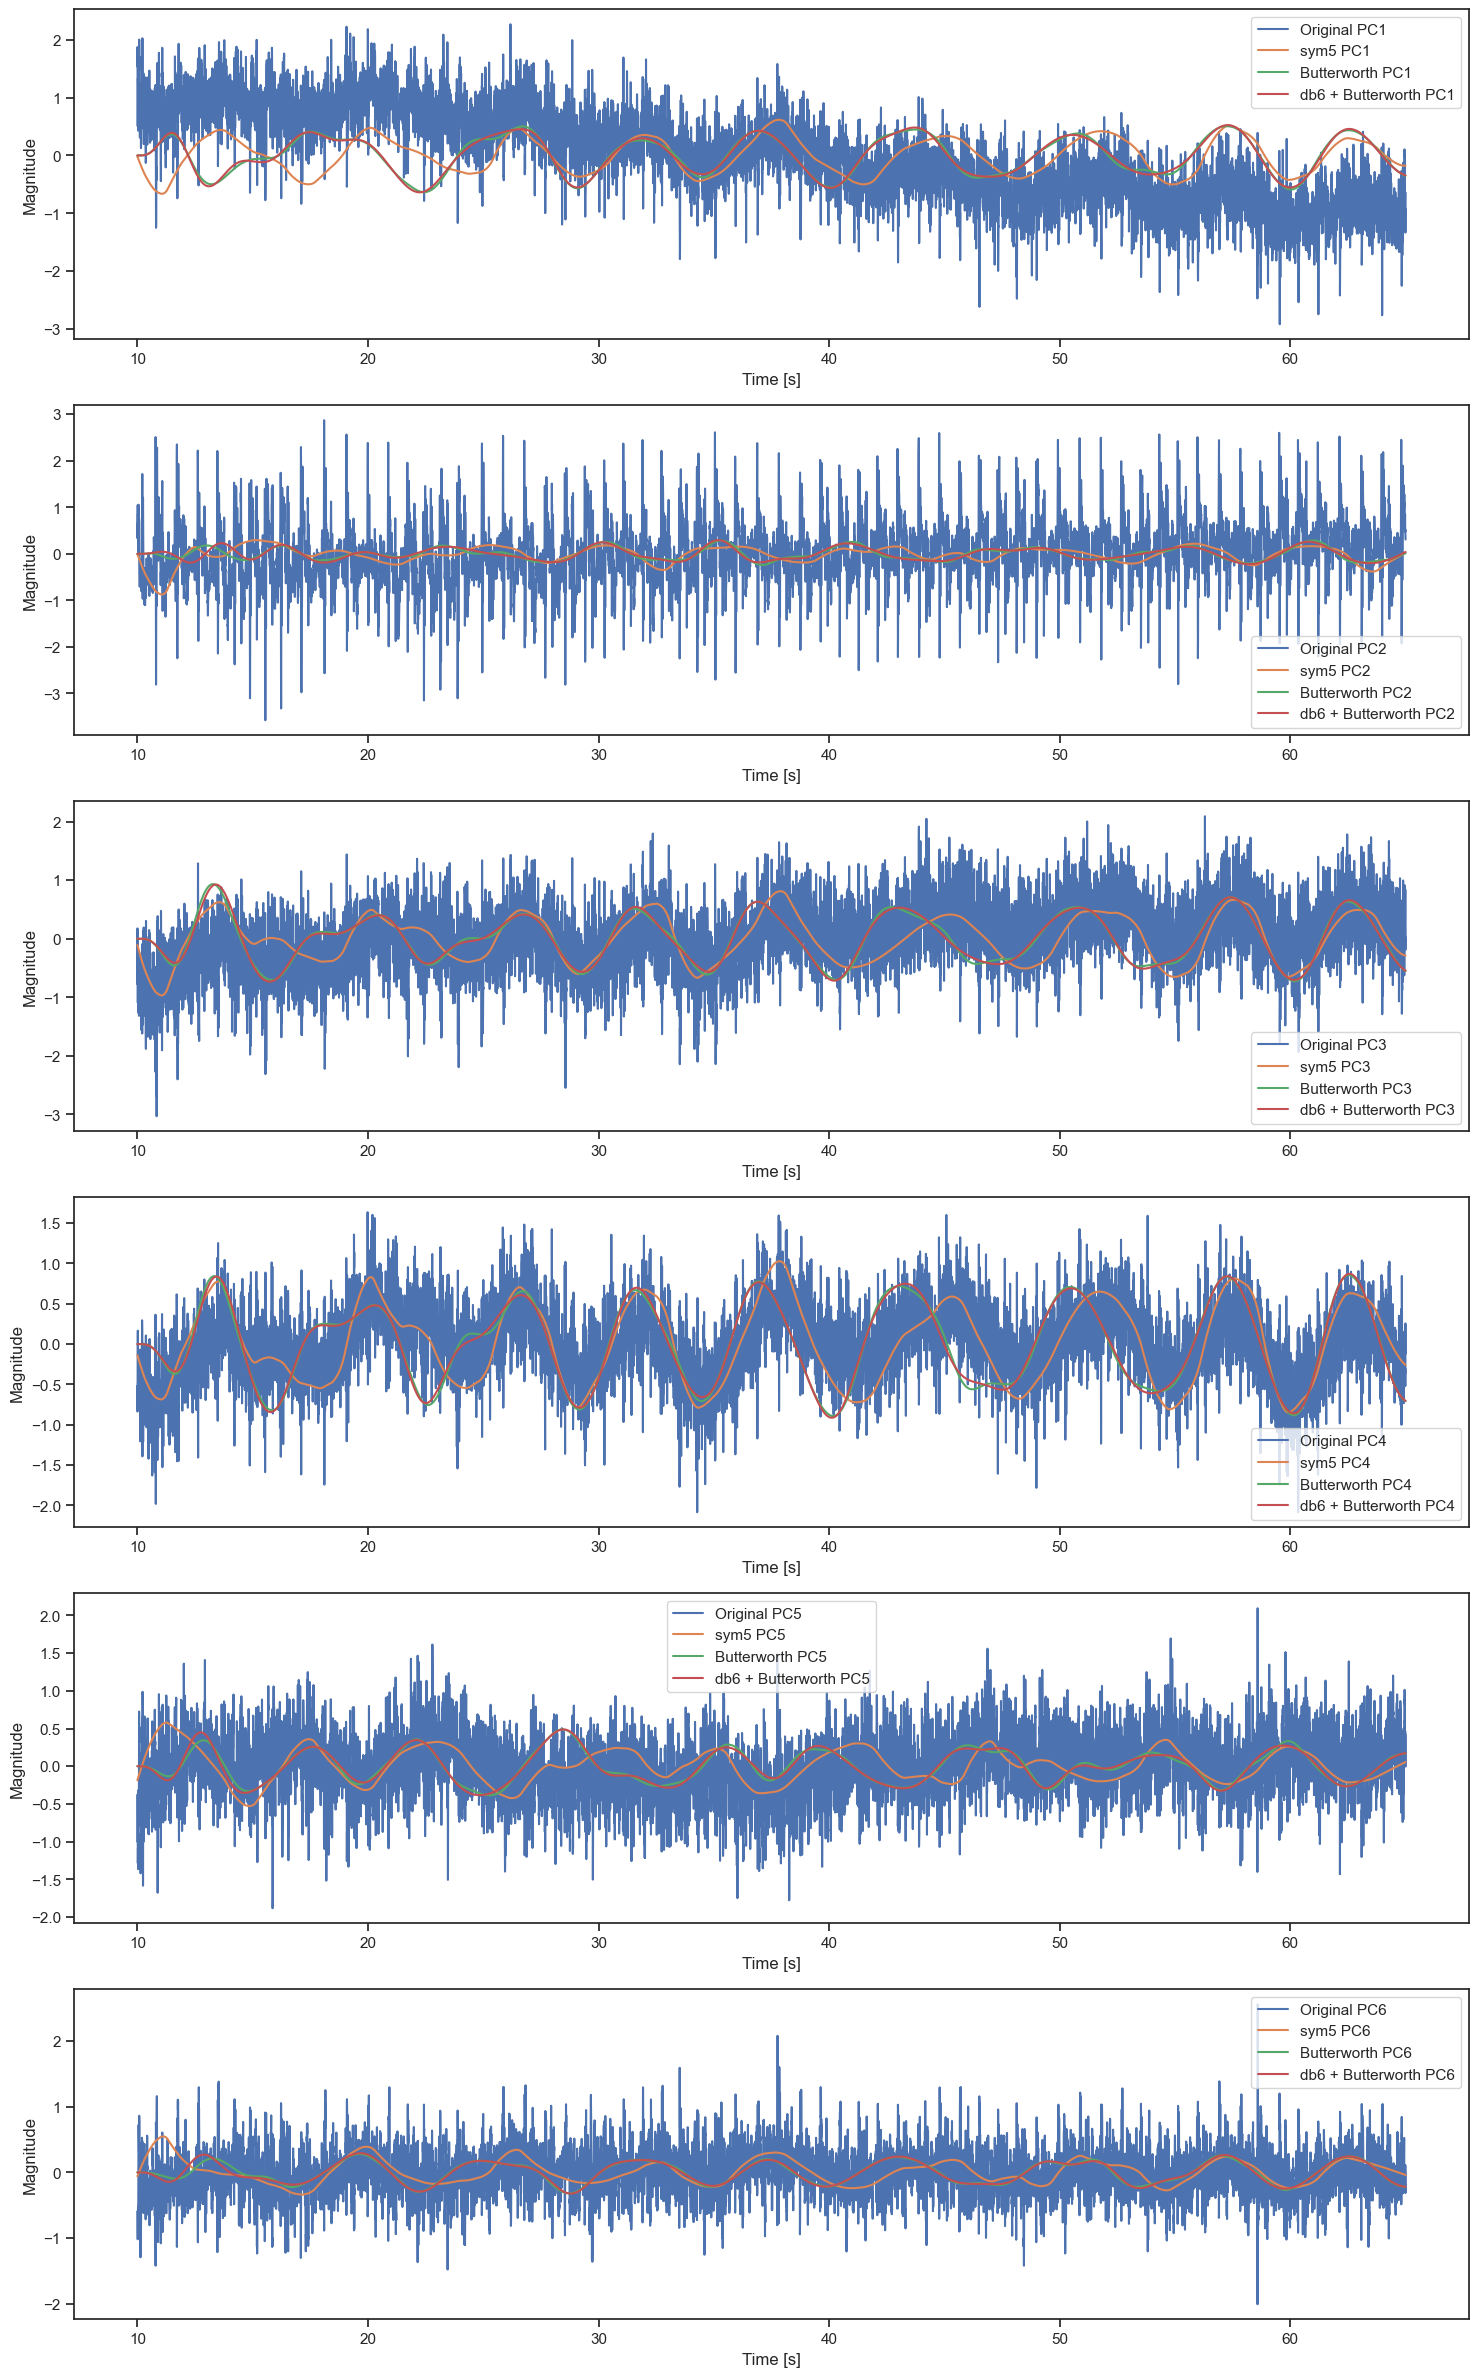

In [28]:
#plot recostructed time signal
fig, axs = plt.subplots(nrows=N_PCA, ncols=1, figsize=(18, N_PCA*5))

for i in range(N_PCA):
    axs[i].plot(data_pca["Abs Time"], data_pca[PCA_LABELS[i]]/2, label=("Original "+PCA_LABELS[i]))
    axs[i].plot(data_pca["Abs Time"], filtered_sig[i,:-1], label=("sym5 "+PCA_LABELS[i]))
    axs[i].plot(data_pca["Abs Time"], filtered_butter[:, i], label=("Butterworth "+PCA_LABELS[i]))
    axs[i].plot(data_pca["Abs Time"], filtered_wtb[:-1, i], label=("db6 + Butterworth "+PCA_LABELS[i]))
        
    axs[i].set_xlabel("Time [s]")
    axs[i].set_ylabel("Magnitude") # ???
    axs[i].legend(loc="best")